In [282]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy import stats
%matplotlib inline 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.model_selection import cross_validate, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf as acf
from statsmodels.graphics.tsaplots import plot_pacf as pacf
from sklearn.model_selection import TimeSeriesSplit

In [11]:
#Font Sizes
#SMALL_SIZE = 8
#MEDIUM_SIZE = 10
#BIGGER_SIZE = 12

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [244]:
#Read in the data
df = pd.read_csv('/Users/shaunakphatak/Desktop/Springboard-Data-Science-Projects/Springboard-Data-Science/Capstone Project #2/Raw Data_CPCB_Lucknow/Cleaned Data Frames/Lucknow_Pollution_Data.csv')
df.head()

From (Time) To (Time)        Date  PM_25_ug_m3  SO2_ug_m3  \
0  2016-01-01 00:00:00  00:59:00  01/01/2016       315.87      13.08   
1  2016-01-01 01:00:00  01:59:00  01/01/2016       353.05      25.59   
2  2016-01-01 02:00:00  02:59:00  01/01/2016       352.82      12.16   
3  2016-01-01 03:00:00  03:59:00  01/01/2016       264.70      18.25   
4  2016-01-01 04:00:00  04:59:00  01/01/2016       217.19       6.89   

   O3_ug_m3  CO_mg_m3  NOX_ppb  NO2_ug_m3  NO_ug_m3  Temp_C  Rel_Hum_%  \
0       NaN      8.90    25.22      10.36     28.53   14.19        NaN   
1       NaN      9.98    26.18       8.64     31.02   14.03        NaN   
2       NaN     11.63    29.62       4.79     38.34   13.62        NaN   
3       NaN      4.83    18.97      10.63     19.96   13.45        NaN   
4       NaN      2.91     7.53      13.43      2.68   12.97        NaN   

   Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  Bar_P_mmHg    T_m    D_m  \
0           NaN           NaN           NaN         NaN   8.26   7.41   
1           NaN           NaN           NaN         NaN   7.01   7.01   
2           NaN           NaN           NaN         NaN   7.01   7.01   
3           NaN           NaN           NaN         NaN   9.71   9.16   
4           NaN           NaN           NaN         NaN  13.51  12.51   

   RH_NOAA_augroch  
0        94.379038  
1       100.000000  
2       100.000000  
3        96.371457  
4        93.675175

In [13]:
#Convert date column to a date time column and drop unnecessary columns. The ambient and dew temperature as well as relative humidity 
#were used from another source
df['From (Time)'] = pd.to_datetime(df['From (Time)'])
#df['Date'] = pd.to_datetime(df['Date'])
#df['To (Time)'] = pd.to_datetime(df['To (Time)']).dt.time
df.drop(df[['To (Time)','Date','Temp_C','Rel_Hum_%']], axis = 1,inplace=True)

In [14]:
df.dtypes

From (Time)        datetime64[ns]
PM_25_ug_m3               float64
SO2_ug_m3                 float64
O3_ug_m3                  float64
CO_mg_m3                  float64
NOX_ppb                   float64
NO2_ug_m3                 float64
NO_ug_m3                  float64
Wind_spd_m_s              float64
Wind_dir_deg              float64
Solar_R_W_m2              float64
Bar_P_mmHg                float64
T_m                       float64
D_m                       float64
RH_NOAA_augroch           float64
dtype: object

In [15]:
#Set index for plotting time series during later exploration
df = df.set_index('From (Time)')

In [16]:
df.isna().sum()

PM_25_ug_m3         2170
SO2_ug_m3           2363
O3_ug_m3            5059
CO_mg_m3            2257
NOX_ppb             2239
NO2_ug_m3           2334
NO_ug_m3            2799
Wind_spd_m_s       10502
Wind_dir_deg        5356
Solar_R_W_m2        4719
Bar_P_mmHg          4699
T_m                 1222
D_m                 1221
RH_NOAA_augroch     1227
dtype: int64

In [17]:
#Checking missing values
missing = pd.concat([df.isna().sum(), 100 * df.isna().mean()], axis=1)
missing.columns = ['Count','%']
missing.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s     10502  28.891334
Wind_dir_deg      5356  14.734525
O3_ug_m3          5059  13.917469
Solar_R_W_m2      4719  12.982118
Bar_P_mmHg        4699  12.927098
NO_ug_m3          2799   7.700138
SO2_ug_m3         2363   6.500688
NO2_ug_m3         2334   6.420908
CO_mg_m3          2257   6.209078
NOX_ppb           2239   6.159560
PM_25_ug_m3       2170   5.969739
RH_NOAA_augroch   1227   3.375516
T_m               1222   3.361761
D_m               1221   3.359010

Wind speed shows the largest amount of missing data followed by wind direction. The response variable PM25 has 5% of its data missing.
Next, lets check yearly data for proportion of missing values

In [18]:
df_2016 = df.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00',:]
miss_2016 = pd.concat([df_2016.isna().sum(),100*df_2016.isna().mean()],axis=1)
miss_2016.columns = ['Count','%']
miss_2016.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      3613  49.083005
Wind_dir_deg      3352  45.537291
O3_ug_m3          3038  41.271566
Bar_P_mmHg        2957  40.171172
Solar_R_W_m2      2954  40.130417
CO_mg_m3           262   3.559299
NO_ug_m3           248   3.369107
PM_25_ug_m3        201   2.730607
SO2_ug_m3          148   2.010596
RH_NOAA_augroch    105   1.426437
D_m                104   1.412852
T_m                103   1.399266
NOX_ppb             72   0.978128
NO2_ug_m3           54   0.733596

In [19]:
df_2017 = df.loc['2017-01-01 00:00:00':'2017-12-31 23:00:00',:]
miss_2017 = pd.concat([df_2017.isna().sum(),100*df_2017.isna().mean()],axis=1)
miss_2017.columns = ['Count','%']
miss_2017.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      1773  20.549374
SO2_ug_m3         1155  13.386648
O3_ug_m3          1132  13.120074
PM_25_ug_m3       1111  12.876681
NO_ug_m3          1082  12.540566
NO2_ug_m3         1077  12.482615
NOX_ppb           1072  12.424664
CO_mg_m3          1055  12.227631
Wind_dir_deg      1044  12.100139
Solar_R_W_m2      1044  12.100139
Bar_P_mmHg        1042  12.076959
RH_NOAA_augroch    138   1.599444
T_m                135   1.564673
D_m                135   1.564673

In [20]:
df_2018 = df.loc['2018-01-01 00:00:00':'2018-12-31 23:00:00',:]
miss_2018 = pd.concat([df_2018.isna().sum(),100*df_2018.isna().mean()],axis=1)
miss_2018.columns = ['Count','%']
miss_2018.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      1413  17.771350
O3_ug_m3           464   5.835744
T_m                396   4.980506
D_m                396   4.980506
RH_NOAA_augroch    396   4.980506
Wind_dir_deg       389   4.892466
SO2_ug_m3          388   4.879889
PM_25_ug_m3        379   4.766696
CO_mg_m3           364   4.578040
NO_ug_m3           339   4.263615
NOX_ppb            334   4.200729
Solar_R_W_m2       334   4.200729
Bar_P_mmHg         334   4.200729
NO2_ug_m3          333   4.188152

In [21]:
df_2019 = df.loc['2019-01-01 00:00:00':'2019-12-31 23:00:00',:]
miss_2019 = pd.concat([df_2019.isna().sum(),100*df_2019.isna().mean()],axis=1)
miss_2019.columns = ['Count','%']
miss_2019.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      2682  33.466434
NO_ug_m3           675   8.422760
NOX_ppb            633   7.898677
NO2_ug_m3          624   7.786374
SO2_ug_m3          452   5.640130
Wind_dir_deg       403   5.028700
CO_mg_m3           378   4.716746
PM_25_ug_m3        324   4.042925
O3_ug_m3           289   3.606189
Solar_R_W_m2       265   3.306713
Bar_P_mmHg         260   3.244322
T_m                 63   0.786124
D_m                 63   0.786124
RH_NOAA_augroch     63   0.786124

The data for year 2016 will be dropped due to a higher number of missing data across multiple variables.

In [22]:
df.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  34180.000000  33987.000000  31291.000000  34093.000000  34111.000000   
mean     132.929899      7.370792     33.938622      1.268223     36.169026   
std      806.804620     25.938703     30.959313      1.073437     41.112612   
min     -971.510000    -72.460000      1.020000      0.010000      1.010000   
25%       49.197500      3.360000     12.160000      0.680000     17.010000   
50%       90.035000      5.210000     25.340000      1.080000     24.990000   
75%      152.162500      8.200000     44.495000      1.480000     39.035000   
max    98301.500000    999.990000    408.640000     19.960000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  34016.000000  33551.000000  25848.000000  30994.000000  31631.000000   
mean      40.845452     18.117006      0.870019    198.146714     68.418477   
std       33.478460     38.145965      1.060821     90.934129    105.620162   
min      -68.230000      1.010000      0.110000      0.150000    -67.430000   
25%       18.790000      6.360000      0.380000    111.425000      2.270000   
50%       30.960000      9.370000      0.640000    215.775000     28.850000   
75%       51.992500     13.505000      0.990000    269.460000     87.060000   
max      999.990000    596.500000      9.990000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  31651.000000  35128.000000  35129.000000     35123.000000  
mean     753.860324     25.713372     18.027448        67.830487  
std       12.453386      8.037360      7.066073        23.150696  
min        2.420000      1.620000     -1.310000         8.009113  
25%      749.050000     20.010000     12.010000        49.937297  
50%      754.860000     27.010000     17.210000        71.098171  
75%      759.410000     31.010000     25.010000        88.506045  
max      771.580000     48.020000     34.015000       115.849321

In [23]:
df1 = df.loc['2017-01-01 00:00:00':'2020-01-01 00:00:00',:]
missing_17_19 = pd.concat([df1.isna().sum(), 100 * df1.isna().mean()], axis=1)
missing_17_19.columns = ['Count', '%']
missing_17_19.sort_values('Count',ascending=False)

Count          %
Wind_spd_m_s      5868  23.859478
NO_ug_m3          2096   8.522404
NOX_ppb           2039   8.290640
NO2_ug_m3         2034   8.270310
SO2_ug_m3         1995   8.111735
O3_ug_m3          1885   7.664471
Wind_dir_deg      1836   7.465235
PM_25_ug_m3       1814   7.375783
CO_mg_m3          1798   7.310726
Solar_R_W_m2      1643   6.680491
Bar_P_mmHg        1636   6.652029
RH_NOAA_augroch    597   2.427421
T_m                594   2.415223
D_m                594   2.415223

A dataset for 2017-2020 is created to be used for modeling purposes as above.
A number of functions are created below for the purposes of data visualization

In [24]:
#Function to plot time series and change duration as needed
def time_series(DF,param,start='2017-01-01 00:00:00',end=None):
    plt.figure()
    t_df = DF.loc[start:end,param]
    t_df.plot(figsize=(15,10))
    plt.xlabel('Time')
    plt.ylabel(param)

In [25]:
#Function to check distributions of variables with and without log transformation
def Dist(df,param,param1):
    gs = gridspec.GridSpec(2,2)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(gs[0,0])
    ax1.title.set_text('Distribution for ' + param)
    sns.distplot(df[param],kde=False,hist_kws=dict(alpha=0.7),ax=ax1);
    #sns.distplot(df[param1],kde=False,hist_kws=dict(alpha=0.9),ax=ax1);
    ax2 = fig.add_subplot(gs[0,1])
    ax2.title.set_text('Distribution for log (' + param + ' + 1)')
    sns.distplot(df[param1],kde=False,hist_kws=dict(alpha=0.7),ax=ax2);
    ax3 = fig.add_subplot(gs[1,0])
    ax3.title.set_text('Boxplot for ' + param)
    sns.boxplot(x=df[param],ax=ax3)
    ax4 = fig.add_subplot(gs[1,1])
    ax4.title.set_text('Boxplot for log (' + param + ' + 1)')
    sns.boxplot(x=df[param1],ax=ax4)
    plt.tight_layout()

In [26]:
#Function to plot variables based on monthly as well as hourly values
def fgrid(df,x,y='PM_25_ug_m3',col='Month'):
    plt.figure(figsize=(15,10));
    g = sns.FacetGrid(df, col=col,col_wrap=4);
    g.map(sns.scatterplot, x,y);
    
def plots_2d(df,x,y='PM_25_ug_m3',mon=True,hour=True):
    plt.figure(figsize=[10,7])
    sns.scatterplot(x=x,y=y,data=df1)
    if mon == True:
        fgrid(df1,x=x,col='Month')
    if hour == True:
        fgrid(df1,x=x,col='Hour')

In [27]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22780.000000  22599.000000  22709.000000  22796.000000  22555.000000   
mean     114.125220      8.224607     34.812659      1.259228     38.024548   
std       97.236663     31.489619     32.273082      1.042414     40.843307   
min      -81.000000     -3.640000      1.020000      0.010000      1.060000   
25%       47.935000      3.540000     12.250000      0.650000     19.310000   
50%       90.945000      5.570000     24.060000      1.010000     25.950000   
75%      151.192500      8.990000     46.060000      1.530000     40.690000   
max     2461.800000    999.990000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22560.000000  22498.000000  18726.000000  22758.000000  22951.000000   
mean      43.434126     18.610433      0.732364    196.091990     65.466089   
std       33.018648     36.762339      0.486056     91.556869    100.055560   
min      -68.230000      1.010000      0.110000      0.150000    -67.430000   
25%       22.540000      7.550000      0.390000    108.000000      2.300000   
50%       33.020000     10.000000      0.650000    215.330000     22.800000   
75%       53.670000     13.830000      0.980000    264.860000     86.270000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  22958.000000  24000.000000  24000.000000     23997.000000  
mean     753.434985     25.918305     18.172730        67.590347  
std       11.580506      8.063605      7.123012        23.185439  
min      249.470000      1.620000     -1.310000         8.009113  
25%      748.200000     20.247500     12.010000        49.490689  
50%      754.140000     27.460000     18.010000        70.658840  
75%      759.470000     31.510000     25.010000        88.687983  
max      771.580000     48.020000     34.015000       115.849321

Negative values found in multiple variables are replaced with NaN.

In [28]:
#Changing incorrect negative entries to missing values (NaN)
cs = ['PM_25_ug_m3', 'SO2_ug_m3', 'NO2_ug_m3', 'Solar_R_W_m2']
for a in cs:
    df1 = df1.copy()
    df1.loc[df1[a]<0,a] = np.nan

In [29]:
df1.isna().sum()

PM_25_ug_m3        1821
SO2_ug_m3          2014
O3_ug_m3           1885
CO_mg_m3           1798
NOX_ppb            2039
NO2_ug_m3          2042
NO_ug_m3           2096
Wind_spd_m_s       5868
Wind_dir_deg       1836
Solar_R_W_m2       1743
Bar_P_mmHg         1636
T_m                 594
D_m                 594
RH_NOAA_augroch     597
dtype: int64

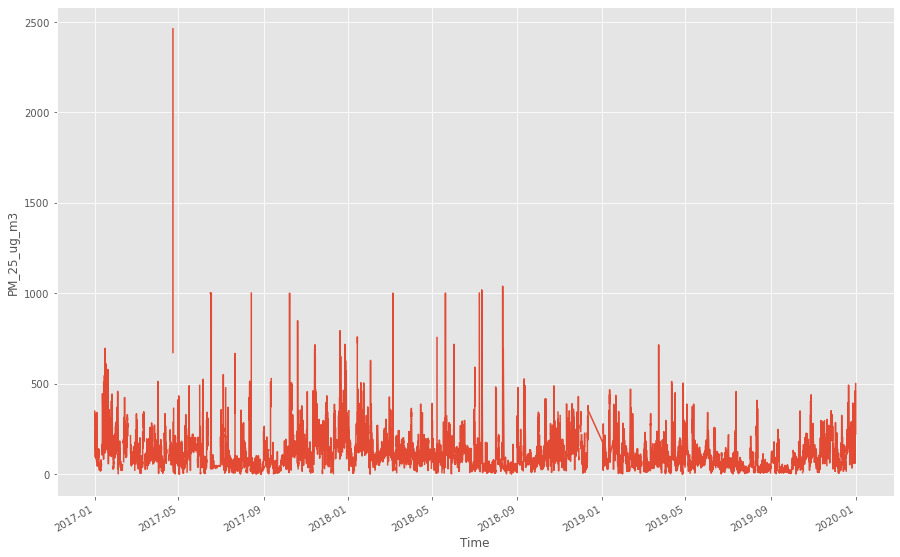

In [30]:
time_series(df1,'PM_25_ug_m3','2017-01-01 00:00:00',)

As seen, most values are within 500 ug/m3 with a few close to 1000 ug/m3. The 2400 value at 2017-04-24 13:00:00 can be changed to a missing value

In [31]:
#Replacing high values (>1100 ug/m3) for PM_25 (2461 ug/m3) at 2017-04-24 13:00:00 with NaN
df1 = df1.copy()
print(df1.loc['2017-04-23 13:00:00','PM_25_ug_m3'])
df1.loc[(df1['PM_25_ug_m3']>1100),'PM_25_ug_m3'] = np.NaN
print(df1.loc['2017-04-23 13:00:00','PM_25_ug_m3'])

From (Time)
2017-04-23 13:00:00    2461.8
Name: PM_25_ug_m3, dtype: float64
From (Time)
2017-04-23 13:00:00   NaN
Name: PM_25_ug_m3, dtype: float64


In [32]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22771.000000  22580.000000  22709.000000  22796.000000  22555.000000   
mean     113.994796      8.232955     34.812659      1.259228     38.024548   
std       95.411087     31.501538     32.273082      1.042414     40.843307   
min        0.010000      0.010000      1.020000      0.010000      1.060000   
25%       47.965000      3.540000     12.250000      0.650000     19.310000   
50%       90.950000      5.570000     24.060000      1.010000     25.950000   
75%      151.195000      9.000000     46.060000      1.530000     40.690000   
max     1038.500000    999.990000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22552.000000  22498.000000  18726.000000  22758.000000  22851.000000   
mean      43.456825     18.610433      0.732364    196.091990     65.758424   
std       32.999854     36.762339      0.486056     91.556869    100.174727   
min        0.030000      1.010000      0.110000      0.150000      0.010000   
25%       22.550000      7.550000      0.390000    108.000000      2.300000   
50%       33.030000     10.000000      0.650000    215.330000     23.470000   
75%       53.682500     13.830000      0.980000    264.860000     86.765000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

         Bar_P_mmHg           T_m           D_m  RH_NOAA_augroch  
count  22958.000000  24000.000000  24000.000000     23997.000000  
mean     753.434985     25.918305     18.172730        67.590347  
std       11.580506      8.063605      7.123012        23.185439  
min      249.470000      1.620000     -1.310000         8.009113  
25%      748.200000     20.247500     12.010000        49.490689  
50%      754.140000     27.460000     18.010000        70.658840  
75%      759.470000     31.510000     25.010000        88.687983  
max      771.580000     48.020000     34.015000       115.849321

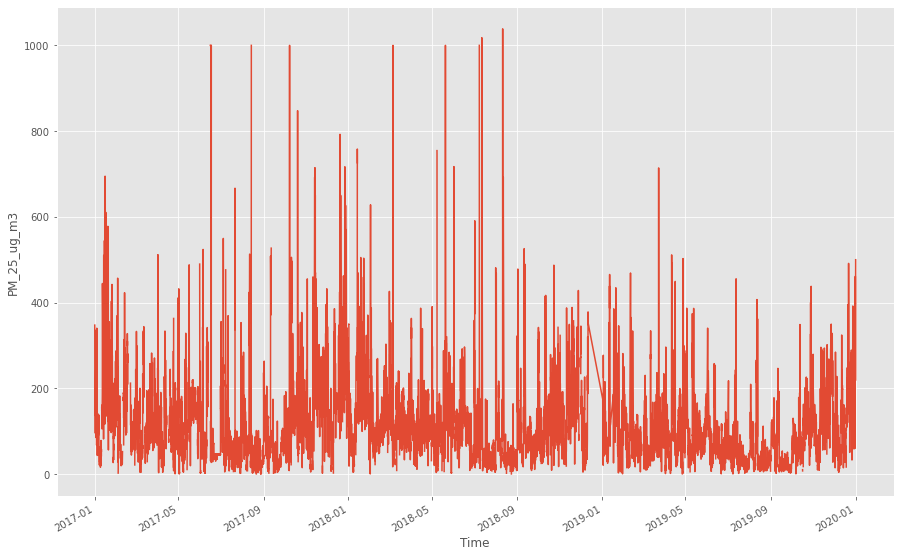

In [33]:
time_series(df1,'PM_25_ug_m3','2017-01-01 00:00:00',)

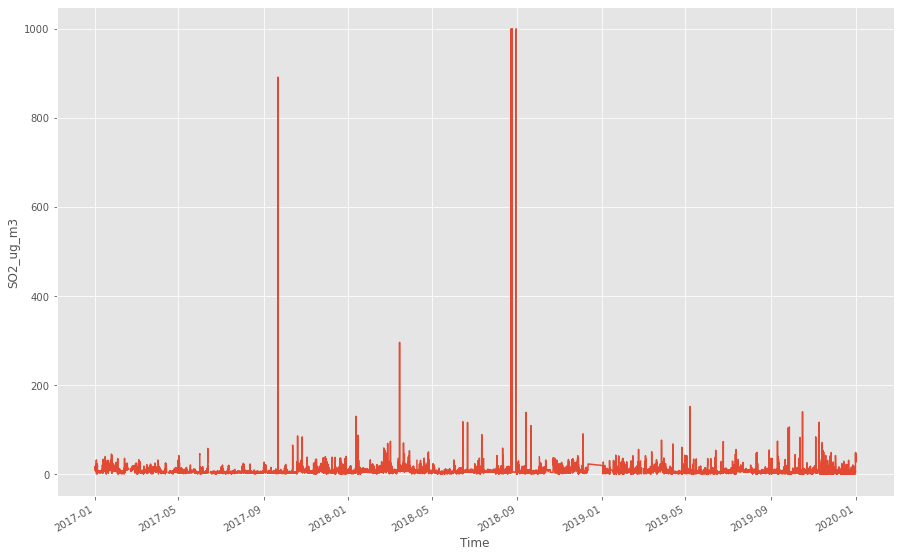

In [34]:
time_series(df1,'SO2_ug_m3','2017-01-01 00:00:00',)

SO2 has most data below 400 ug/m3 with a few outliers. These can again be replaced with a null value

In [35]:
df1.loc[df1['SO2_ug_m3']>800]['SO2_ug_m3']

From (Time)
2017-09-21 15:00:00    828.95
2017-09-21 21:00:00    859.59
2017-09-21 22:00:00    891.55
2018-08-23 02:00:00    999.99
2018-08-23 03:00:00    999.99
2018-08-23 04:00:00    999.99
2018-08-23 05:00:00    999.99
2018-08-23 06:00:00    999.99
2018-08-23 07:00:00    999.99
2018-08-23 08:00:00    999.99
2018-08-23 09:00:00    999.99
2018-08-23 10:00:00    999.99
2018-08-23 11:00:00    999.99
2018-08-23 20:00:00    999.99
2018-08-24 02:00:00    999.99
2018-08-24 03:00:00    999.99
2018-08-24 10:00:00    999.99
2018-08-24 11:00:00    999.99
2018-08-30 12:00:00    999.99
Name: SO2_ug_m3, dtype: float64

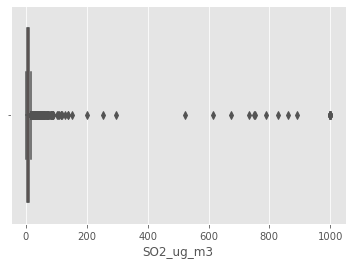

In [36]:
sns.boxplot(df1['SO2_ug_m3'])

In [37]:
#Replacing SO2 ug/m3 outliers (>400 ug/m3) with NaN
df1 = df1.copy()
df1.loc[(df1['SO2_ug_m3']>400),'SO2_ug_m3'] = np.NaN

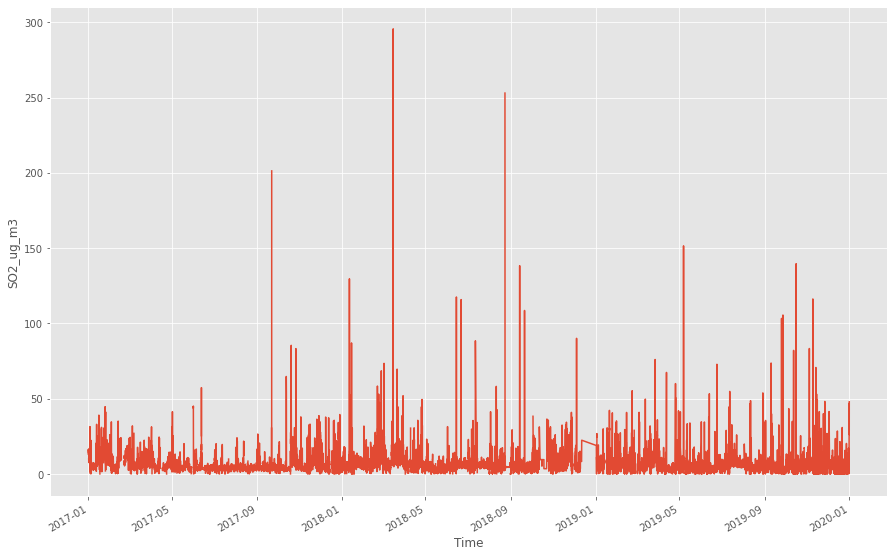

In [38]:
time_series(df1,'SO2_ug_m3','2017-01-01 00:00:00',)

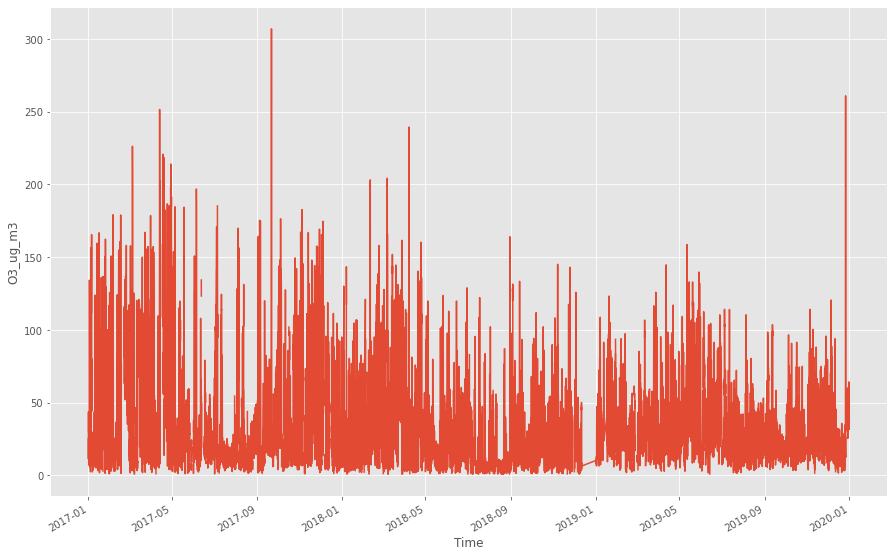

In [39]:
time_series(df1,'O3_ug_m3','2017-01-01 00:00:00',)

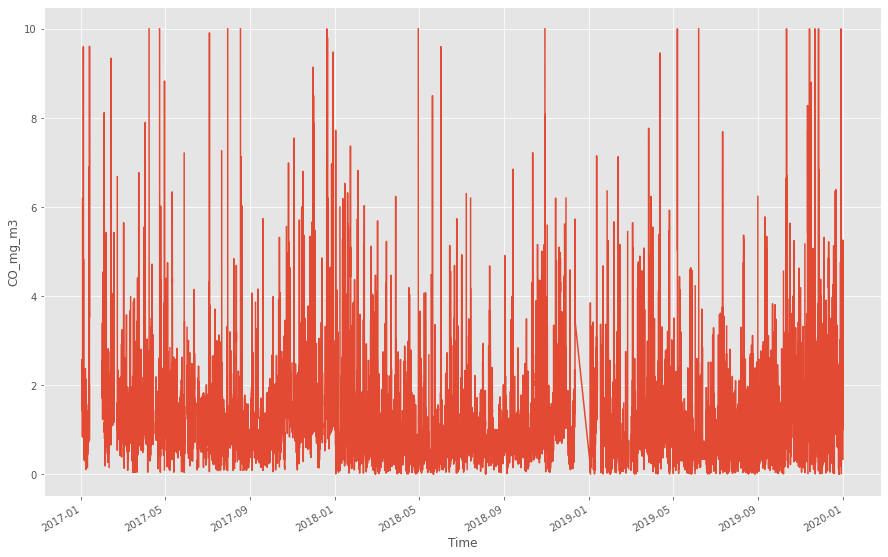

In [40]:
time_series(df1,'CO_mg_m3','2017-01-31 00:00:00',)

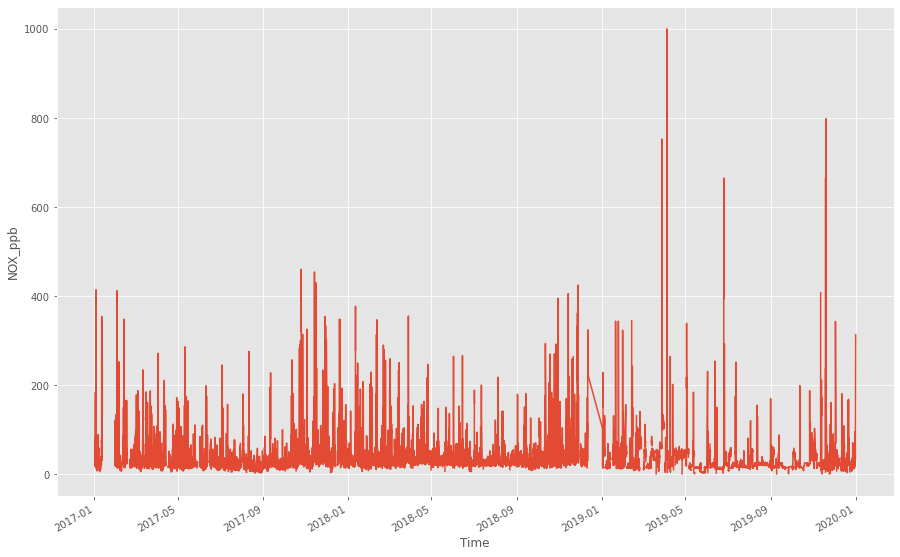

In [41]:
time_series(df1,'NOX_ppb','2017-01-31 00:00:00',)

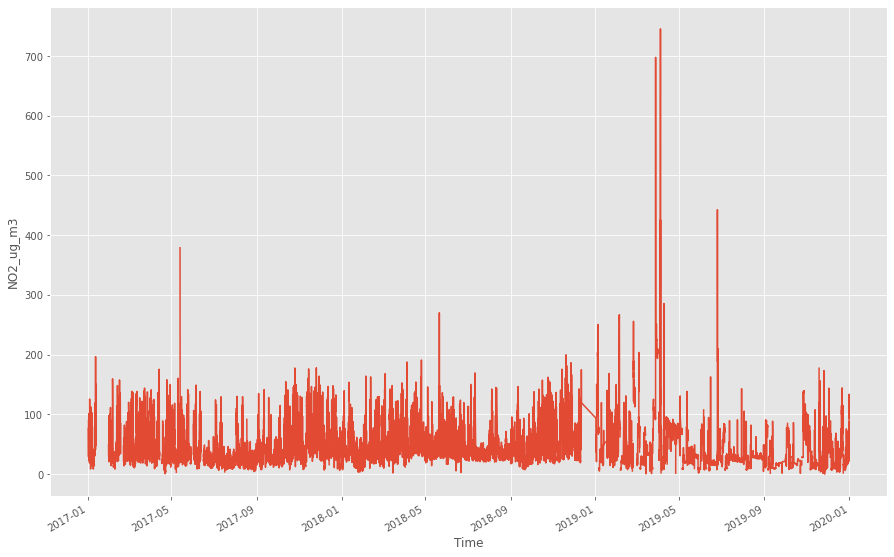

In [42]:
time_series(df1,'NO2_ug_m3','2017-01-31 00:00:00',)

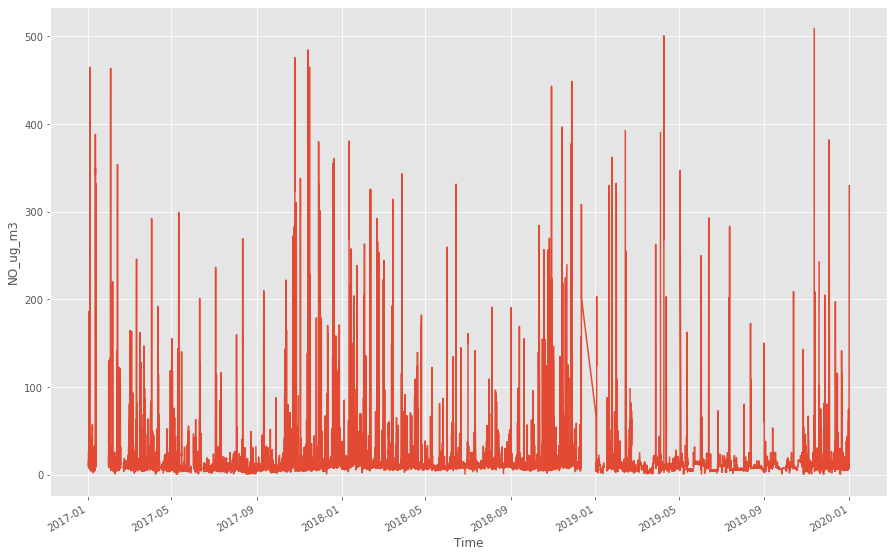

In [43]:
time_series(df1,'NO_ug_m3','2017-01-31 00:00:00',)

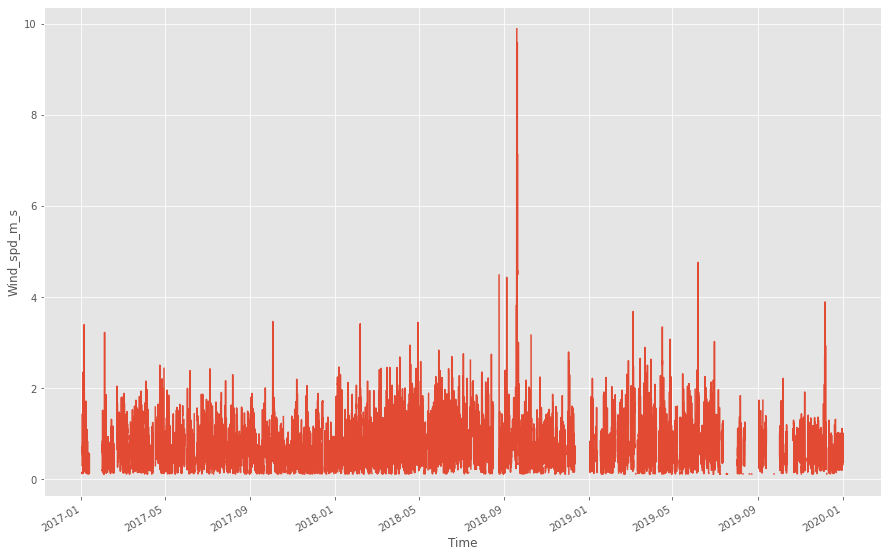

In [44]:
time_series(df1,'Wind_spd_m_s','2017-01-31 00:00:00',)

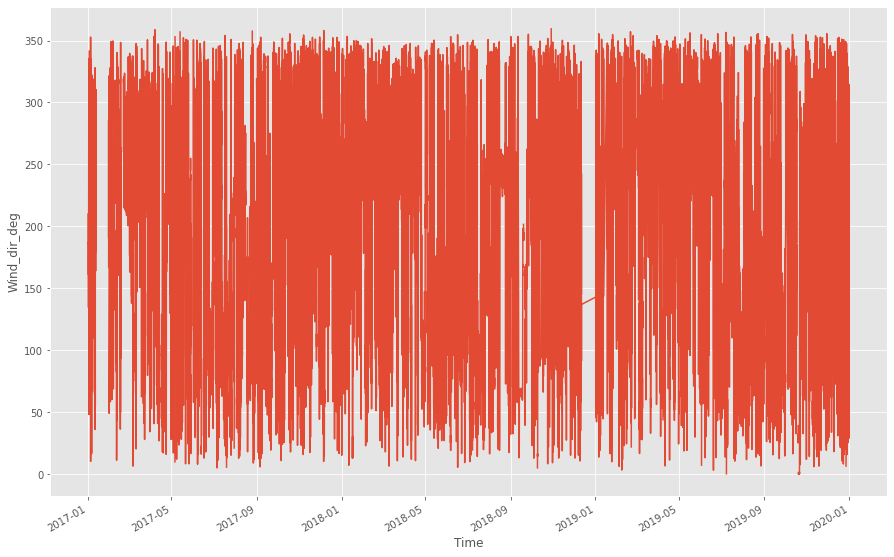

In [45]:
time_series(df1,'Wind_dir_deg','2017-01-31 00:00:00',)

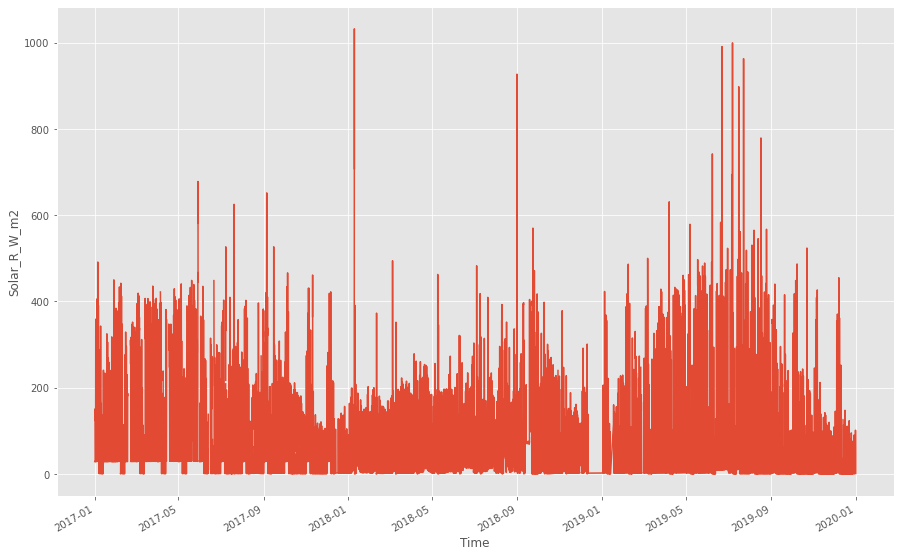

In [46]:
time_series(df1,'Solar_R_W_m2','2017-01-01 00:00:00')

Apart from PM and SO2, none of the other outliers were changed. Next we can plot histograms for all the variables.

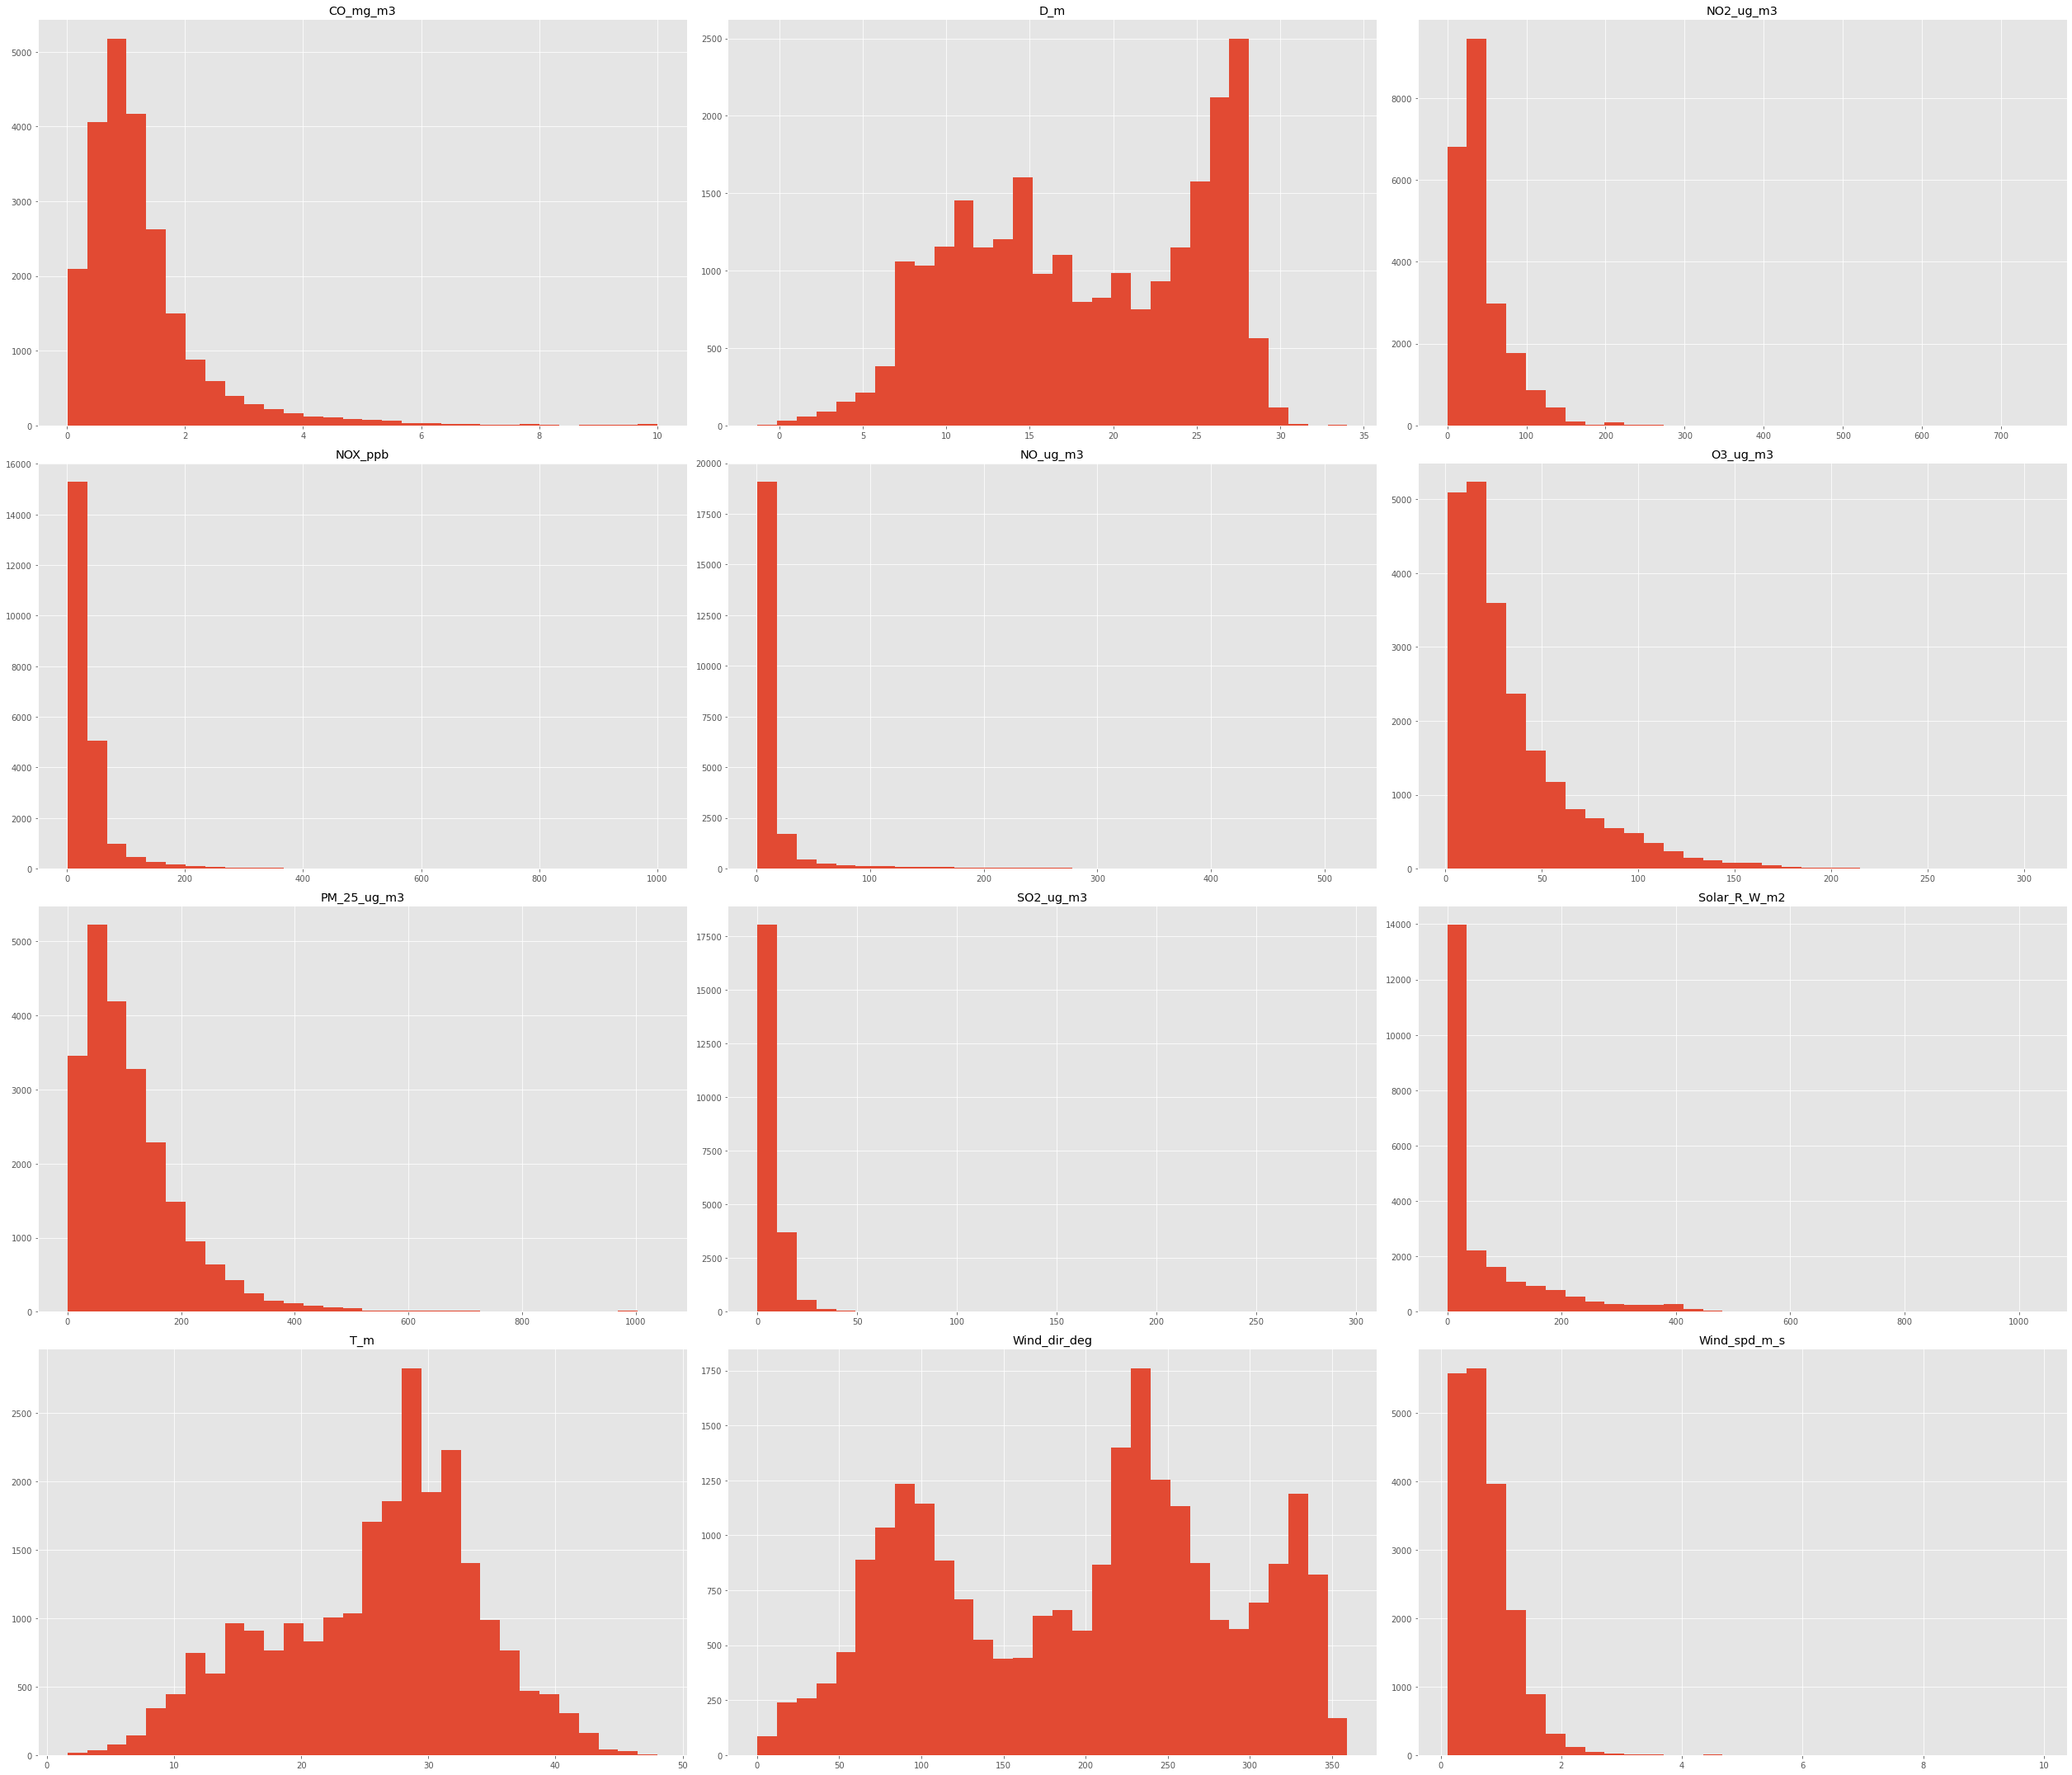

In [47]:
clmns = ['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3','NOX_ppb', 'NO2_ug_m3', 'NO_ug_m3','Wind_spd_m_s', 
     'Wind_dir_deg', 'Solar_R_W_m2', 'T_m','D_m']
df1[clmns].hist(figsize=[35,30],bins=30);
plt.tight_layout()

Most parameters (CO, NO2, NOX, NO, O3, PM25, SO2, Wind Speed and Solar Radiation) show a right skewed distribution.
<br> These parameters can be log transformed to make the distribution more normal and also reduce the influence of outliers for some models. This transformation may help more when trying to use linear regression and not so much while applying bagging and boosting techniques

In [48]:
#Log Transform features to reduce skewed variables seen in the histograms above
clmns_log = [c + '_log' for c in clmns]
for a,b in zip(clmns_log,clmns):
    df1[a] = (df1[b]+1).transform(np.log)
clmns

['PM_25_ug_m3',
 'SO2_ug_m3',
 'O3_ug_m3',
 'CO_mg_m3',
 'NOX_ppb',
 'NO2_ug_m3',
 'NO_ug_m3',
 'Wind_spd_m_s',
 'Wind_dir_deg',
 'Solar_R_W_m2',
 'T_m',
 'D_m']

Plotting non-log vs log distributions to check shape

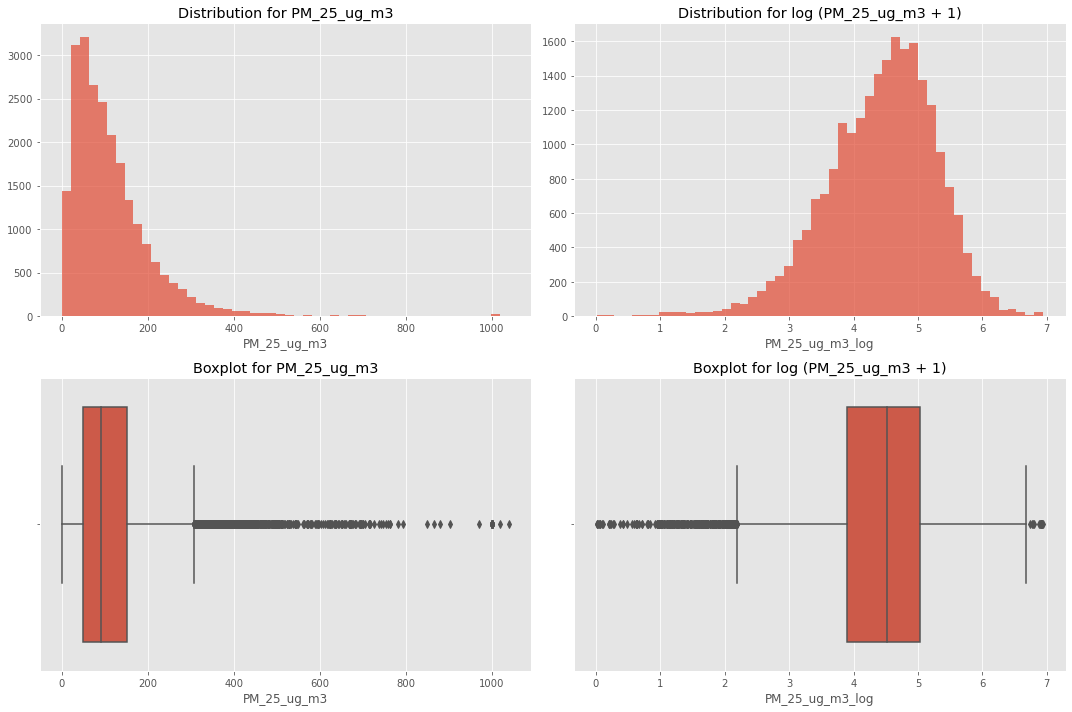

In [49]:
Dist(df1,'PM_25_ug_m3','PM_25_ug_m3_log')

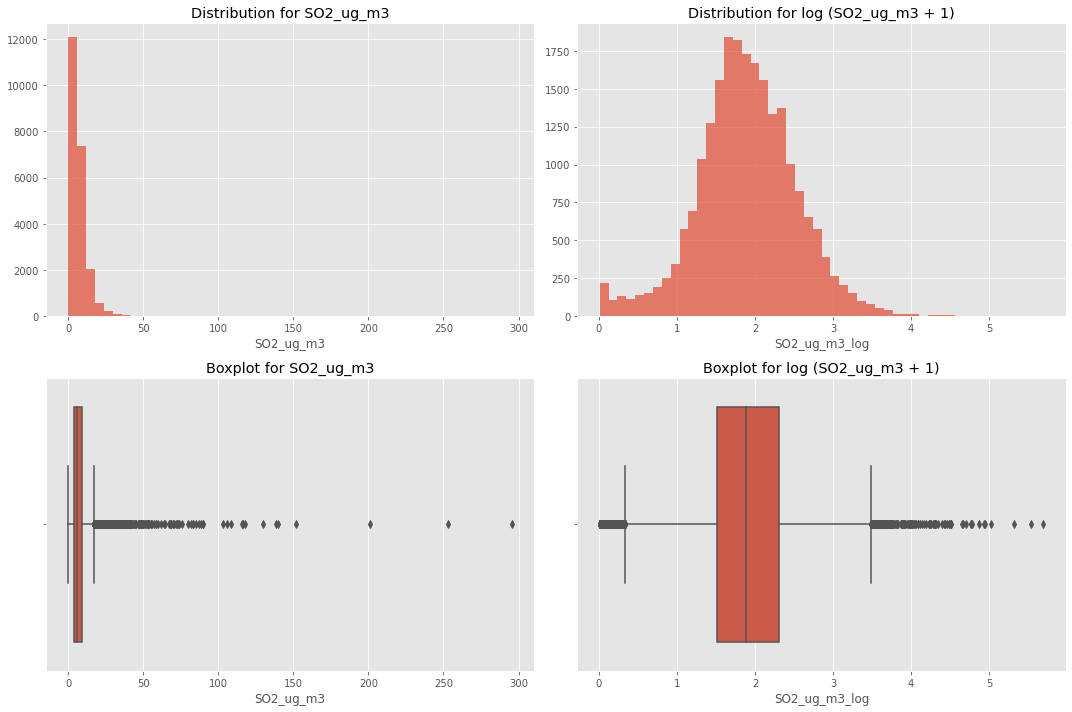

In [50]:
Dist(df1,'SO2_ug_m3','SO2_ug_m3_log')

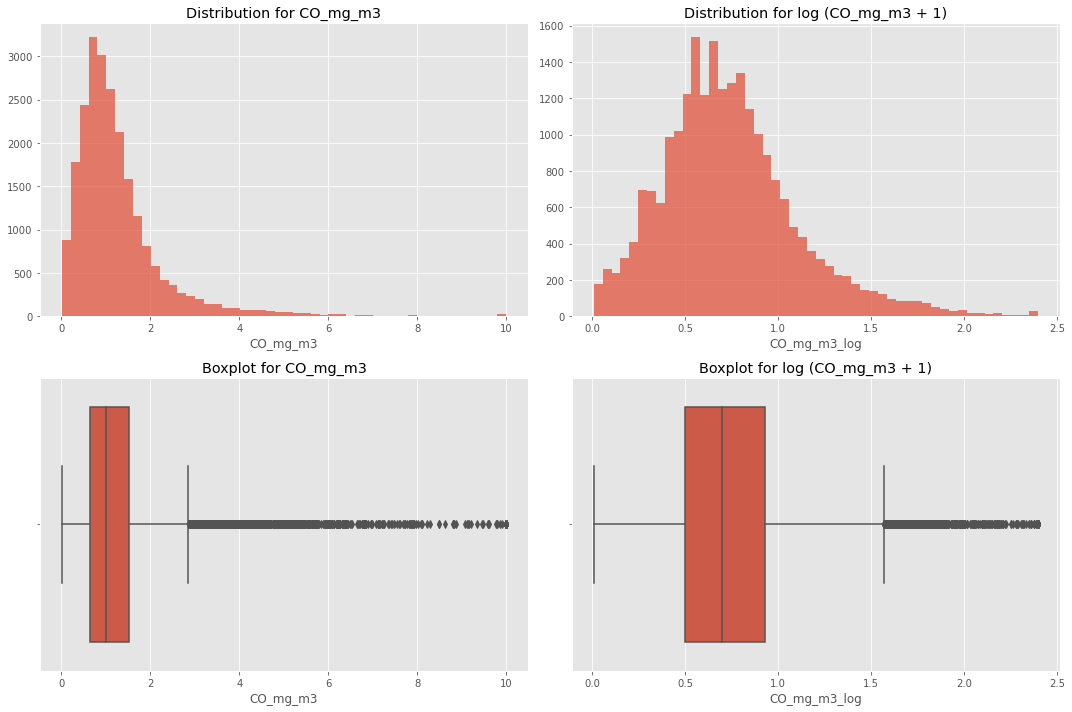

In [51]:
Dist(df1,'CO_mg_m3','CO_mg_m3_log')

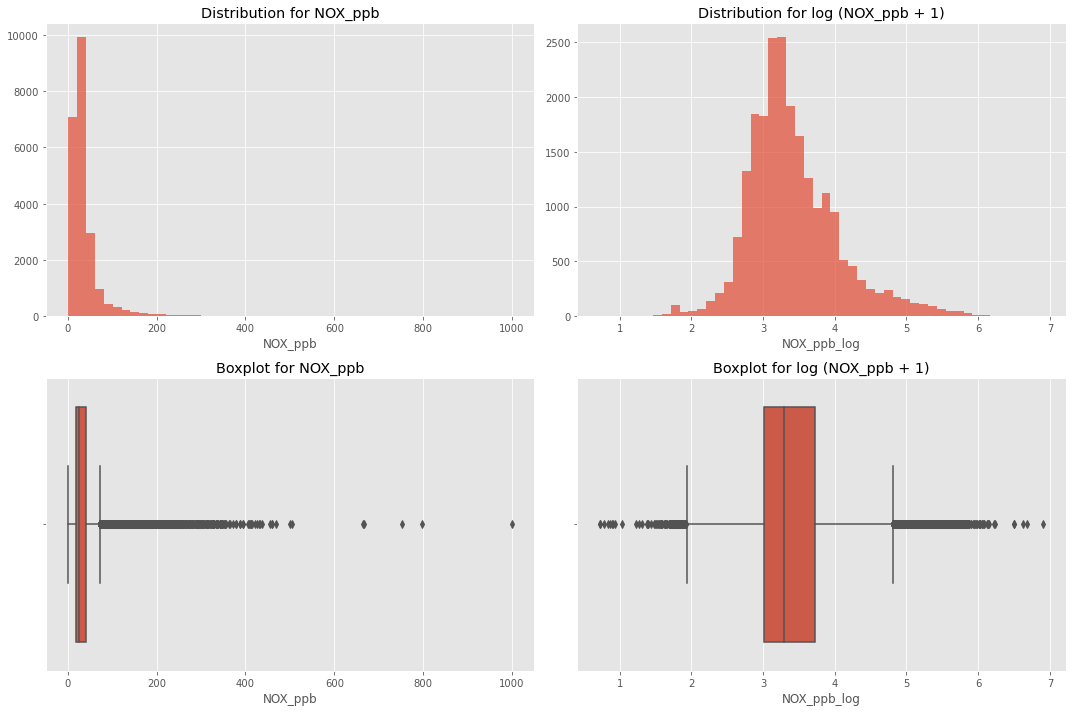

In [52]:
Dist(df1,'NOX_ppb','NOX_ppb_log')

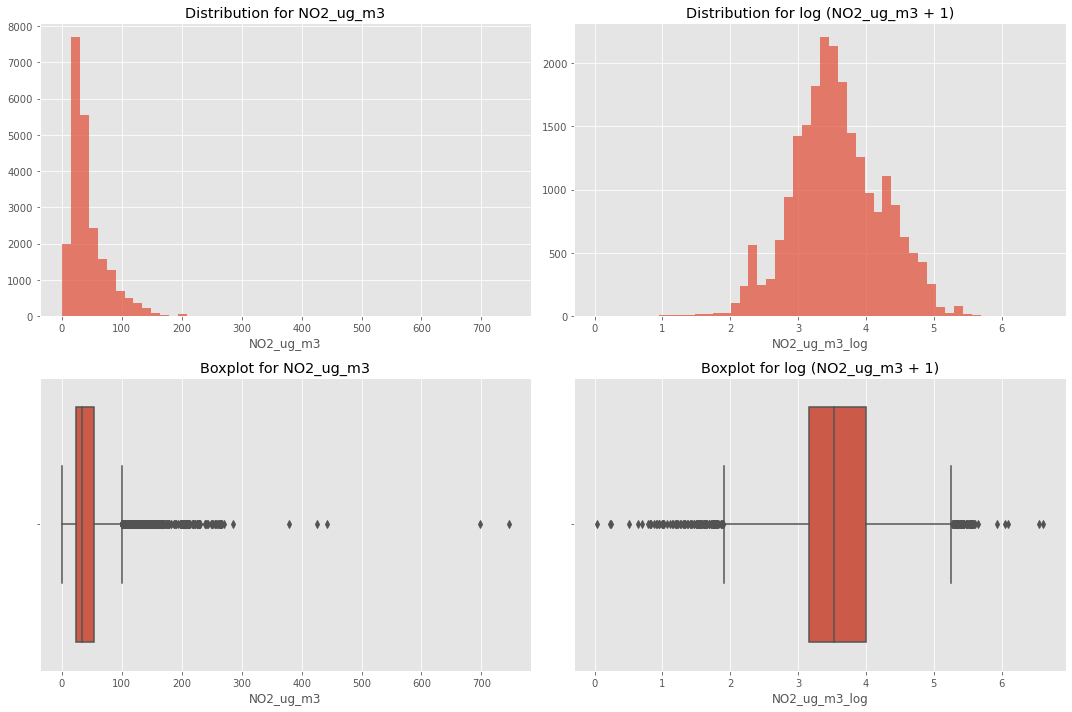

In [53]:
Dist(df1,'NO2_ug_m3','NO2_ug_m3_log')

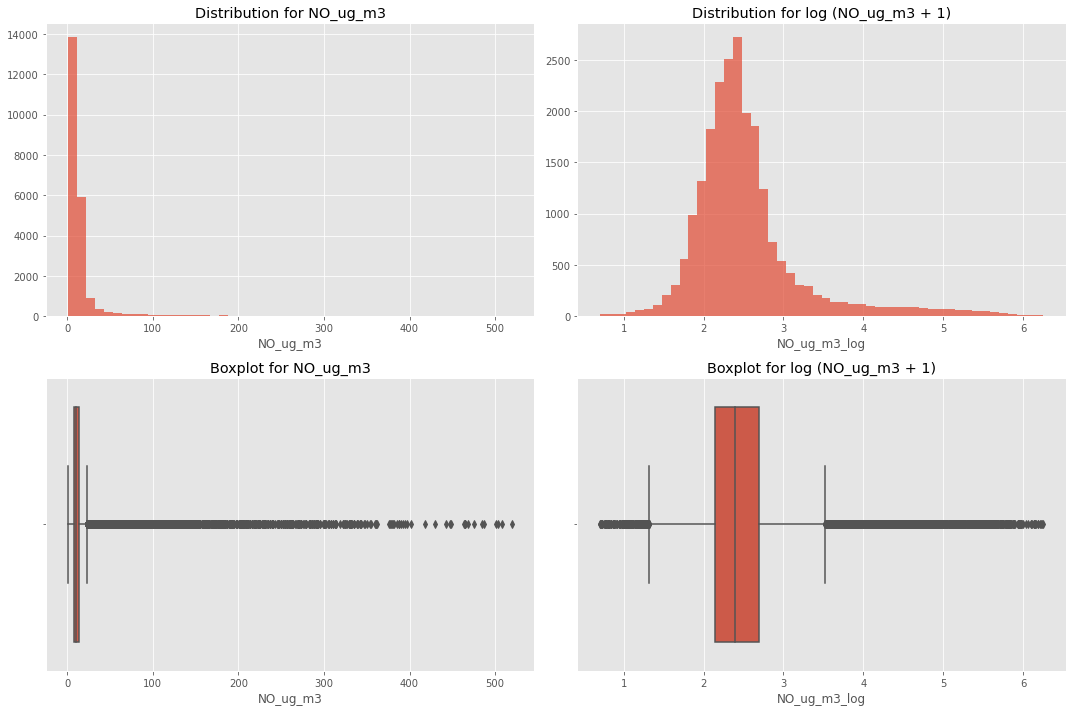

In [54]:
Dist(df1,'NO_ug_m3','NO_ug_m3_log')

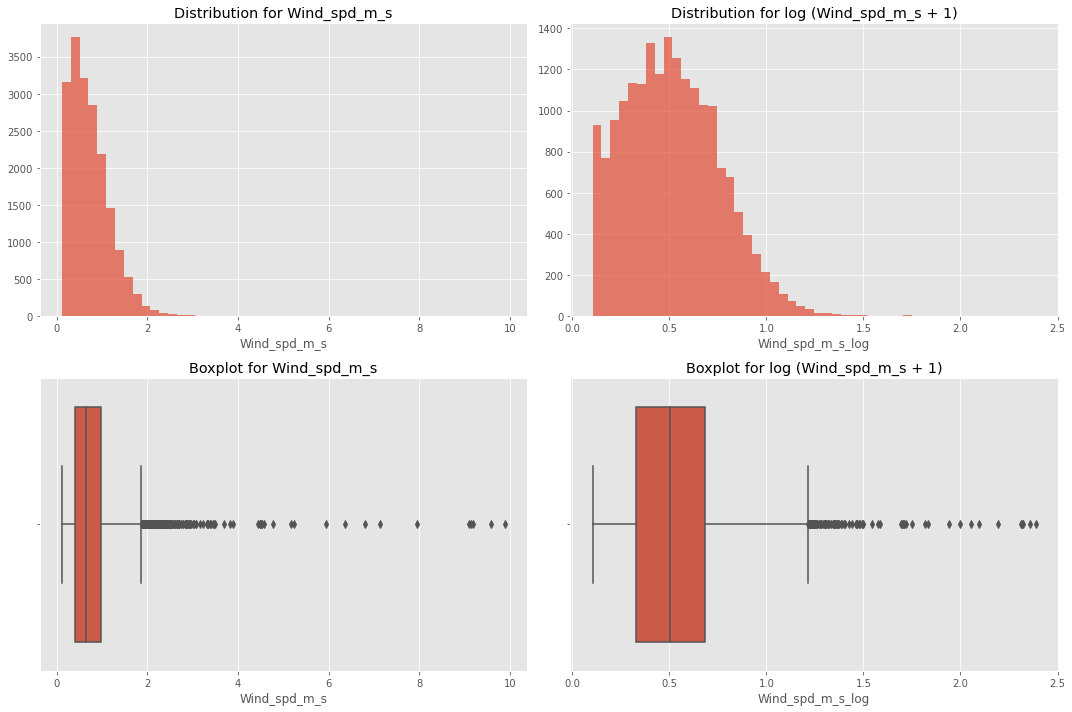

In [55]:
Dist(df1,'Wind_spd_m_s','Wind_spd_m_s_log')

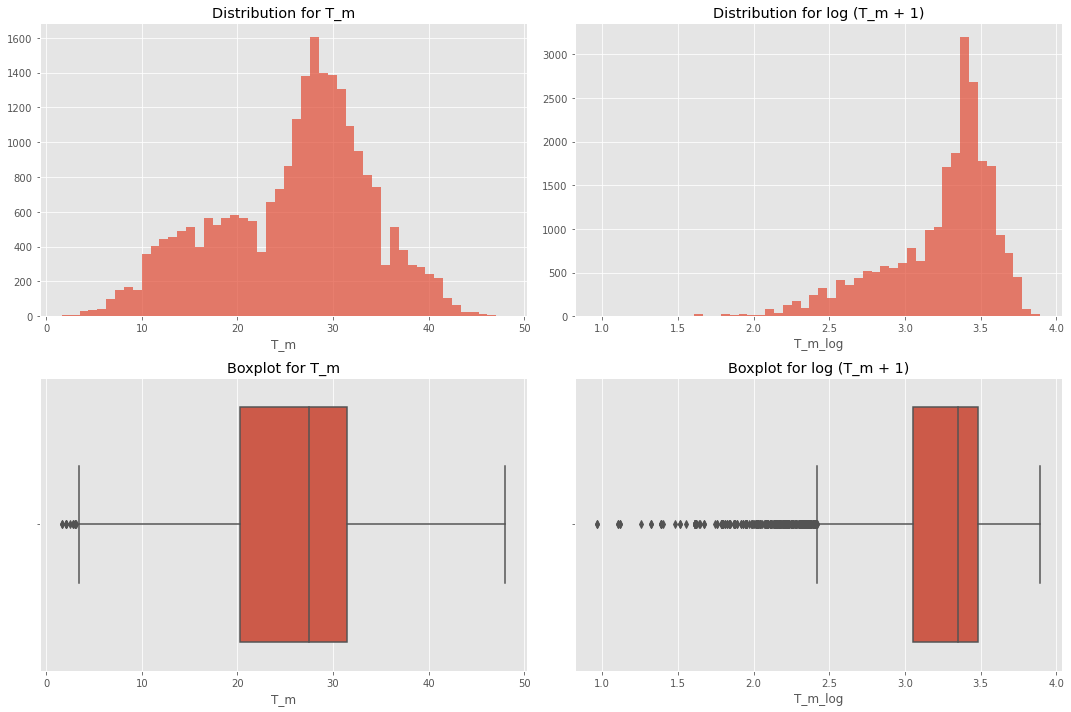

In [56]:
Dist(df1,'T_m','T_m_log')

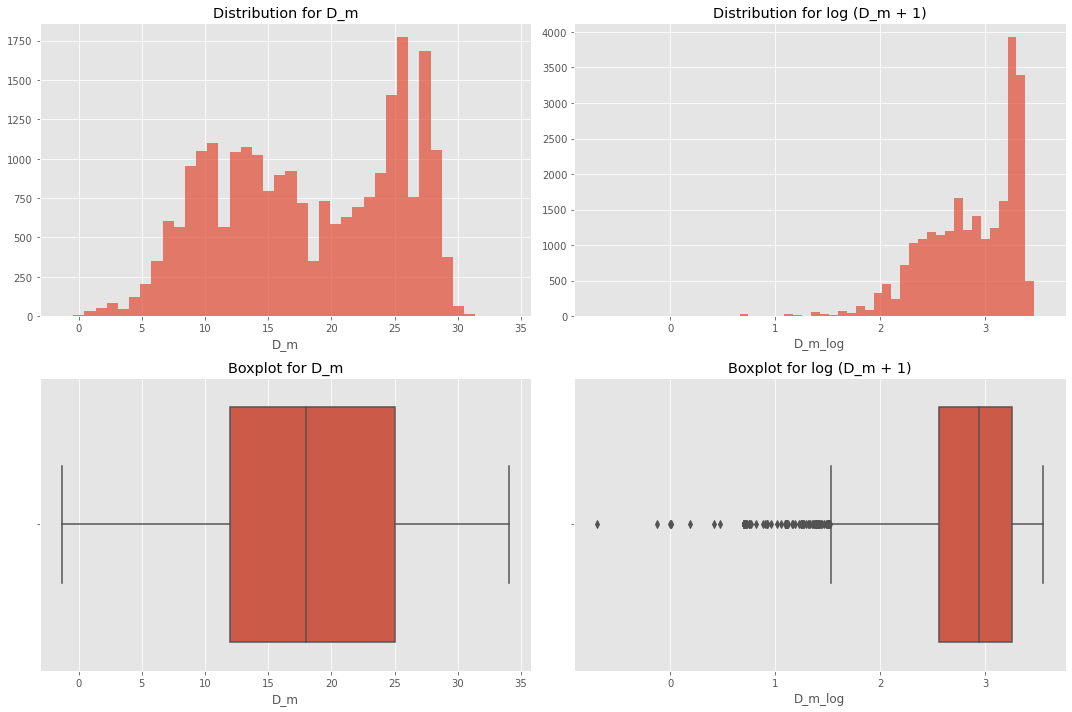

In [57]:
Dist(df1,'D_m','D_m_log')

Except temperatures and Wind speed, all the log transformed variables are seen to be more symmetrically distributed.

In [58]:
df1.isna().sum()

PM_25_ug_m3         1823
SO2_ug_m3           2040
O3_ug_m3            1885
CO_mg_m3            1798
NOX_ppb             2039
NO2_ug_m3           2042
NO_ug_m3            2096
Wind_spd_m_s        5868
Wind_dir_deg        1836
Solar_R_W_m2        1743
Bar_P_mmHg          1636
T_m                  594
D_m                  594
RH_NOAA_augroch      597
PM_25_ug_m3_log     1823
SO2_ug_m3_log       2040
O3_ug_m3_log        1885
CO_mg_m3_log        1798
NOX_ppb_log         2039
NO2_ug_m3_log       2042
NO_ug_m3_log        2096
Wind_spd_m_s_log    5868
Wind_dir_deg_log    1836
Solar_R_W_m2_log    1743
T_m_log              594
D_m_log              595
dtype: int64

In [59]:
df1.resample('1H').mean().isna().sum()

PM_25_ug_m3         3510
SO2_ug_m3           3727
O3_ug_m3            3572
CO_mg_m3            3485
NOX_ppb             3726
NO2_ug_m3           3729
NO_ug_m3            3783
Wind_spd_m_s        7555
Wind_dir_deg        3523
Solar_R_W_m2        3430
Bar_P_mmHg          3323
T_m                 2281
D_m                 2281
RH_NOAA_augroch     2284
PM_25_ug_m3_log     3510
SO2_ug_m3_log       3727
O3_ug_m3_log        3572
CO_mg_m3_log        3485
NOX_ppb_log         3726
NO2_ug_m3_log       3729
NO_ug_m3_log        3783
Wind_spd_m_s_log    7555
Wind_dir_deg_log    3523
Solar_R_W_m2_log    3430
T_m_log             2281
D_m_log             2282
dtype: int64

As can be seen above, resampling values by '1 hour' introduces many null values indicating missing patches in 
the time series. This can be a problem when adding lagging features as these features will not strictly be previous
hour features for some of these data points.
We can create a separate hourly resampled dataset and compare modeling results between both types of datasets

In [60]:
#Create separate hourly resampled dataset
df1_1H = df1.resample('1H').mean()

In [61]:
df1.equals(df1_1H)

False

To plot feature against time (monthly, hourly values), time features need to be created as follows:

In [62]:
#Date Time Features
def time_features(df):
    df['Year'] = df['From (Time)'].dt.year
    df['Month_No'] = df['From (Time)'].dt.month
    df['Day_of_Week'] = df['From (Time)'].dt.dayofweek
    df['Hour'] = df['From (Time)'].dt.hour
    df['Day'] = df['From (Time)'].dt.day_name()
    df['Month'] = df['From (Time)'].dt.month_name()
    df['Y/M'] = (df['From (Time)'].dt.to_period('M')).dt.strftime('(%Y, %m)')
    return df

In [63]:
df1 = time_features(df1.reset_index()).set_index('From (Time)')
df1_1H = time_features(df1_1H.reset_index()).set_index('From (Time)')

In [64]:
df1.equals(df1_1H)

False

In [65]:
df1.head()

PM_25_ug_m3  SO2_ug_m3  O3_ug_m3  CO_mg_m3  NOX_ppb  \
From (Time)                                                                
2017-01-01 00:00:00       347.28      15.93     25.06      1.25    46.35   
2017-01-01 01:00:00       264.13      15.33     24.01      0.98    36.98   
2017-01-01 02:00:00       198.07      15.31     11.37      1.43    25.26   
2017-01-01 03:00:00       153.30      16.27     30.98      1.42    23.16   
2017-01-01 04:00:00       129.17      12.82     43.70      1.58    20.93   

                     NO2_ug_m3  NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  \
From (Time)                                                            
2017-01-01 00:00:00      31.28     36.71          0.38        175.09   
2017-01-01 01:00:00      29.17     26.39          0.43        183.65   
2017-01-01 02:00:00      27.79     12.64          0.37        111.90   
2017-01-01 03:00:00      26.46     10.88          0.35        146.27   
2017-01-01 04:00:00      26.54      8.05          0.32        112.67   

                     Solar_R_W_m2  ...  Solar_R_W_m2_log   T_m_log   D_m_log  \
From (Time)                        ...                                         
2017-01-01 00:00:00         28.76  ...          3.393165       NaN       NaN   
2017-01-01 01:00:00         28.76  ...          3.393165  2.565718  2.485740   
2017-01-01 02:00:00         28.76  ...          3.393165  2.565718  2.565718   
2017-01-01 03:00:00         28.76  ...          3.393165  2.580974  2.573375   
2017-01-01 04:00:00         28.75  ...          3.392829  2.565718  2.565718   

                     Year  Month_No  Day_of_Week  Hour     Day    Month  \
From (Time)                                                               
2017-01-01 00:00:00  2017         1            6     0  Sunday  January   
2017-01-01 01:00:00  2017         1            6     1  Sunday  January   
2017-01-01 02:00:00  2017         1            6     2  Sunday  January   
2017-01-01 03:00:00  2017         1            6     3  Sunday  January   
2017-01-01 04:00:00  2017         1            6     4  Sunday  January   

                            Y/M  
From (Time)                      
2017-01-01 00:00:00  (2017, 01)  
2017-01-01 01:00:00  (2017, 01)  
2017-01-01 02:00:00  (2017, 01)  
2017-01-01 03:00:00  (2017, 01)  
2017-01-01 04:00:00  (2017, 01)  

[5 rows x 33 columns]

In [66]:
df1_1H.head()

PM_25_ug_m3  SO2_ug_m3  O3_ug_m3  CO_mg_m3  NOX_ppb  \
From (Time)                                                                
2017-01-01 00:00:00       347.28      15.93     25.06      1.25    46.35   
2017-01-01 01:00:00       264.13      15.33     24.01      0.98    36.98   
2017-01-01 02:00:00       198.07      15.31     11.37      1.43    25.26   
2017-01-01 03:00:00       153.30      16.27     30.98      1.42    23.16   
2017-01-01 04:00:00       129.17      12.82     43.70      1.58    20.93   

                     NO2_ug_m3  NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  \
From (Time)                                                            
2017-01-01 00:00:00      31.28     36.71          0.38        175.09   
2017-01-01 01:00:00      29.17     26.39          0.43        183.65   
2017-01-01 02:00:00      27.79     12.64          0.37        111.90   
2017-01-01 03:00:00      26.46     10.88          0.35        146.27   
2017-01-01 04:00:00      26.54      8.05          0.32        112.67   

                     Solar_R_W_m2  ...  Solar_R_W_m2_log   T_m_log   D_m_log  \
From (Time)                        ...                                         
2017-01-01 00:00:00         28.76  ...          3.393165       NaN       NaN   
2017-01-01 01:00:00         28.76  ...          3.393165  2.565718  2.485740   
2017-01-01 02:00:00         28.76  ...          3.393165  2.565718  2.565718   
2017-01-01 03:00:00         28.76  ...          3.393165  2.580974  2.573375   
2017-01-01 04:00:00         28.75  ...          3.392829  2.565718  2.565718   

                     Year  Month_No  Day_of_Week  Hour     Day    Month  \
From (Time)                                                               
2017-01-01 00:00:00  2017         1            6     0  Sunday  January   
2017-01-01 01:00:00  2017         1            6     1  Sunday  January   
2017-01-01 02:00:00  2017         1            6     2  Sunday  January   
2017-01-01 03:00:00  2017         1            6     3  Sunday  January   
2017-01-01 04:00:00  2017         1            6     4  Sunday  January   

                            Y/M  
From (Time)                      
2017-01-01 00:00:00  (2017, 01)  
2017-01-01 01:00:00  (2017, 01)  
2017-01-01 02:00:00  (2017, 01)  
2017-01-01 03:00:00  (2017, 01)  
2017-01-01 04:00:00  (2017, 01)  

[5 rows x 33 columns]

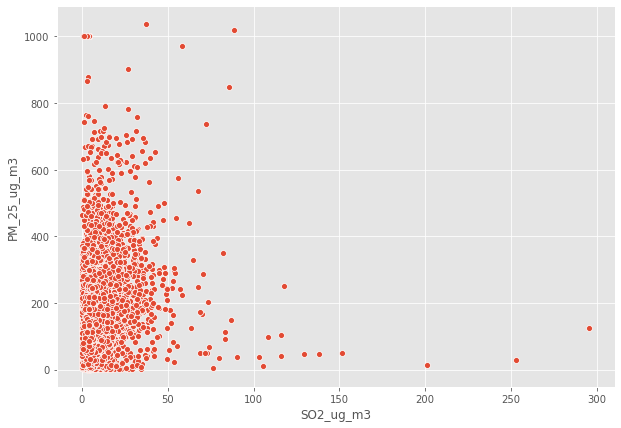

<Figure size 1080x720 with 0 Axes>

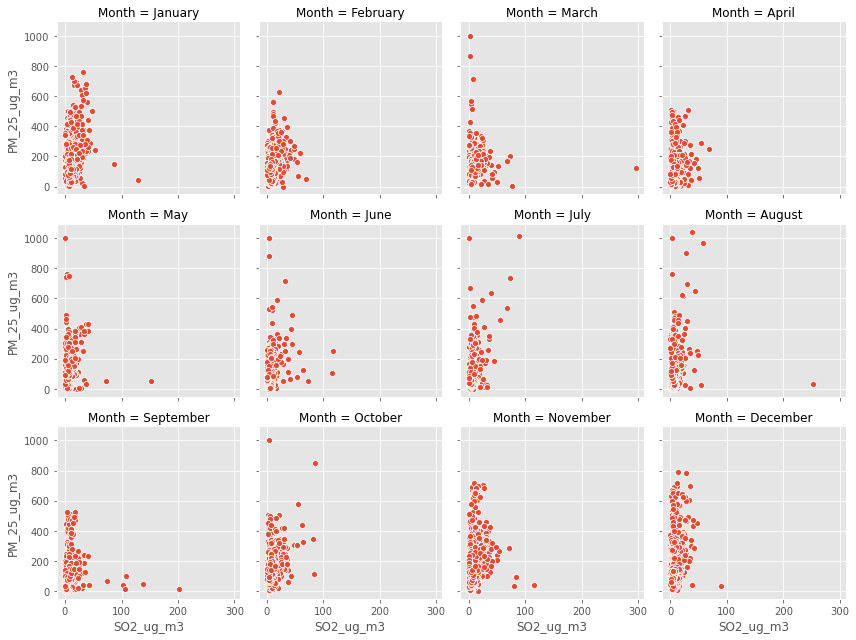

<Figure size 1080x720 with 0 Axes>

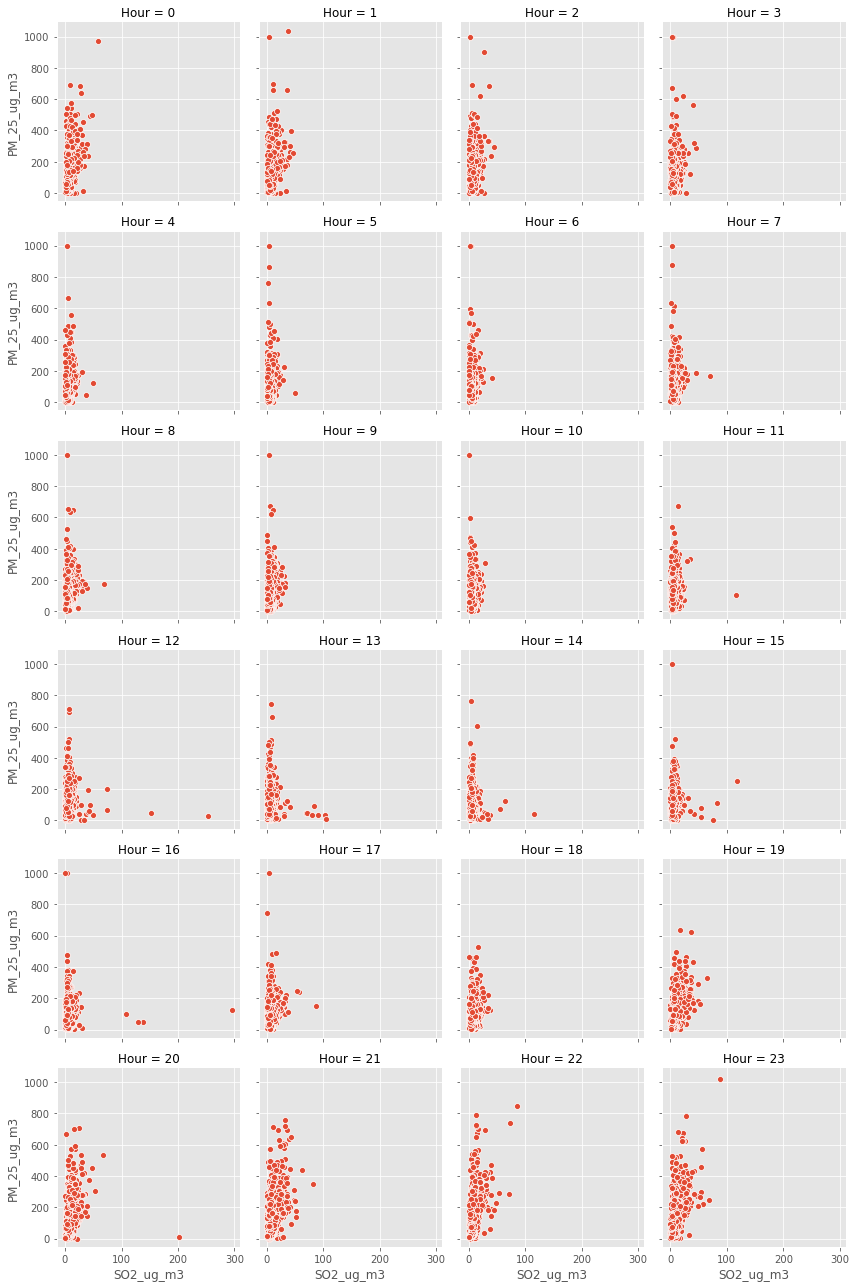

In [67]:
plots_2d(df1,x='SO2_ug_m3')

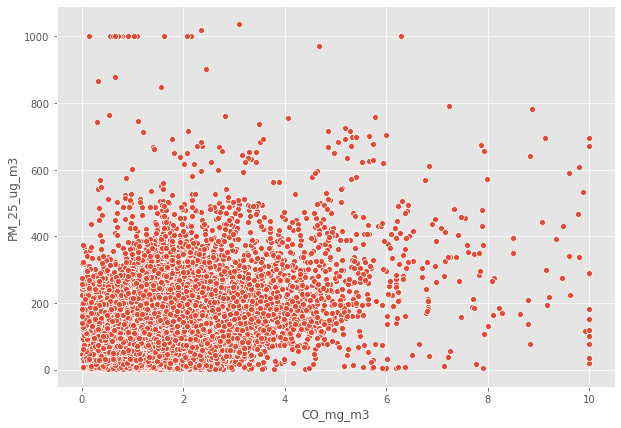

<Figure size 1080x720 with 0 Axes>

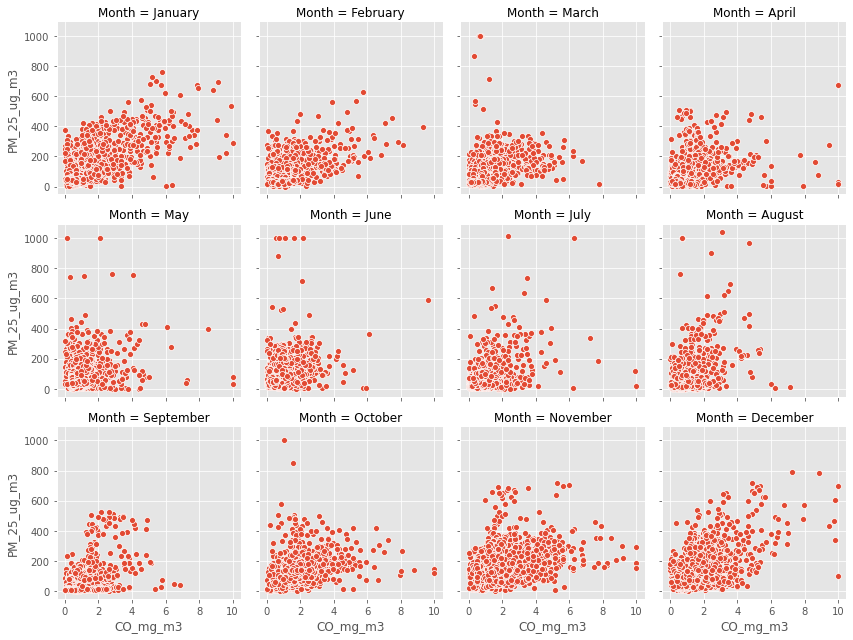

<Figure size 1080x720 with 0 Axes>

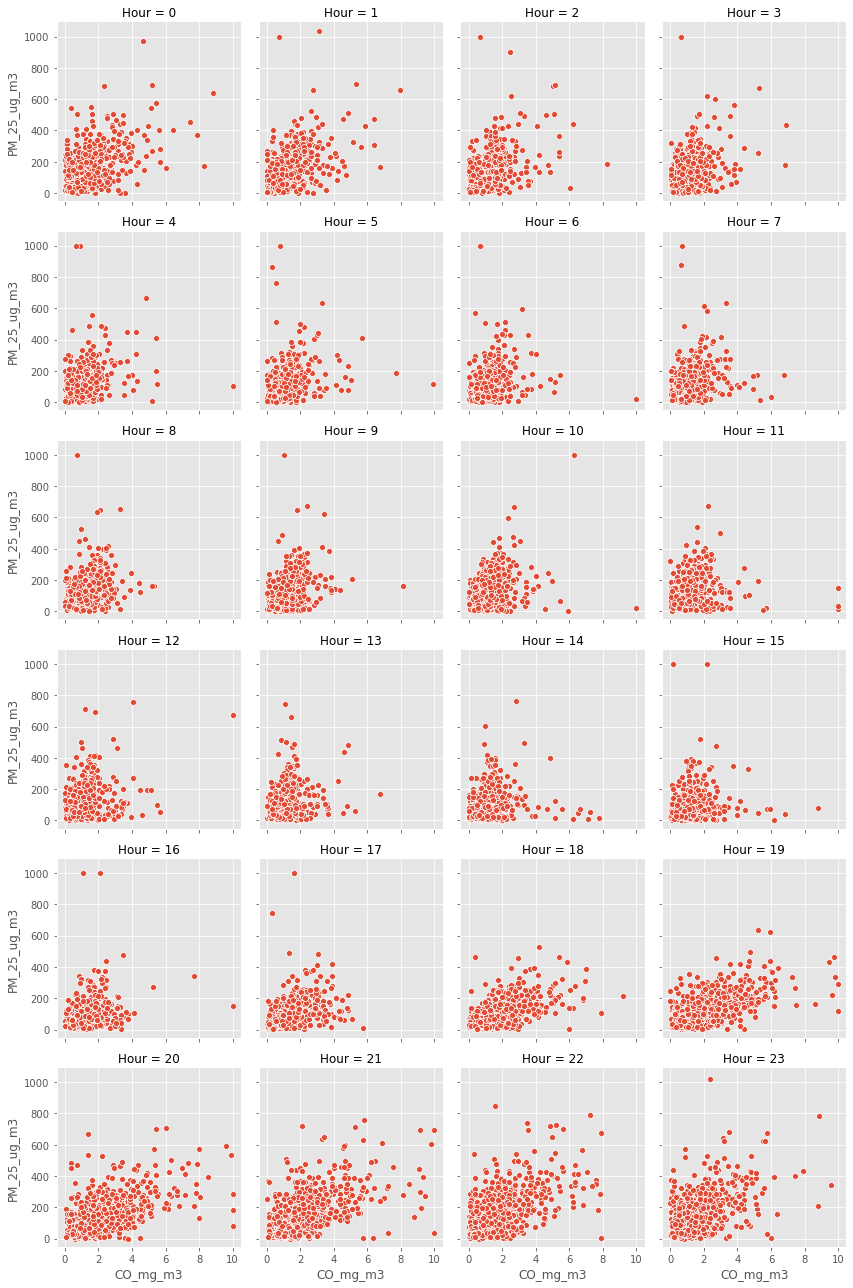

In [61]:
plots_2d(df1,x='CO_mg_m3')

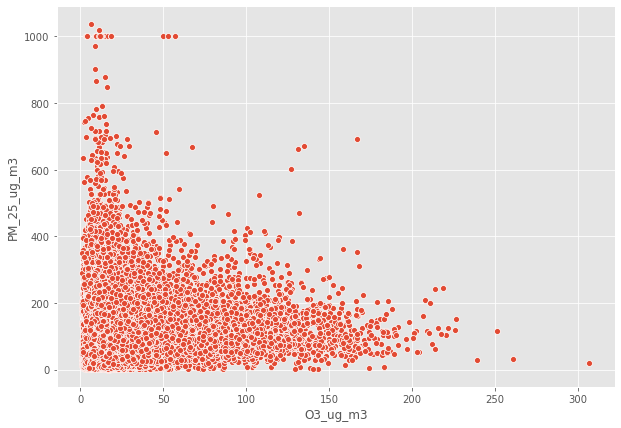

<Figure size 1080x720 with 0 Axes>

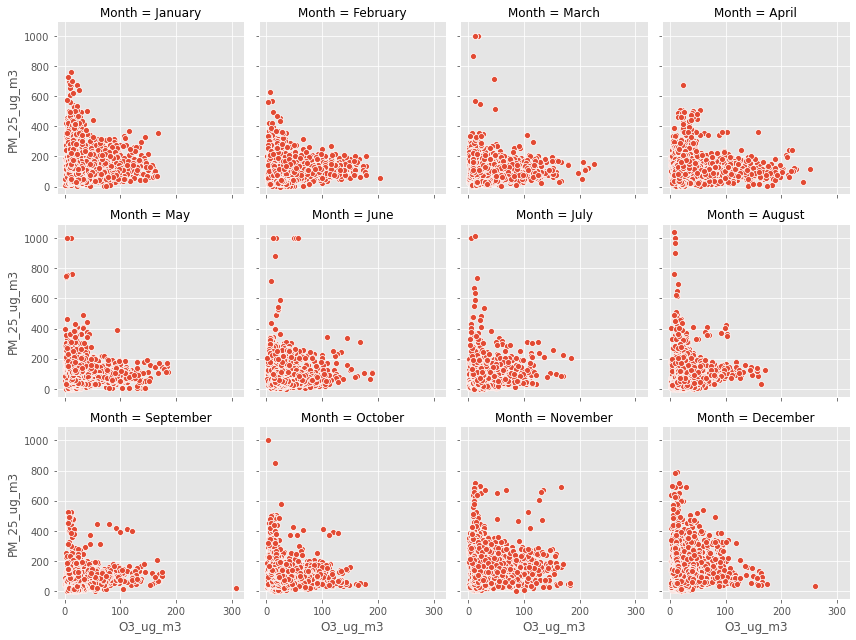

<Figure size 1080x720 with 0 Axes>

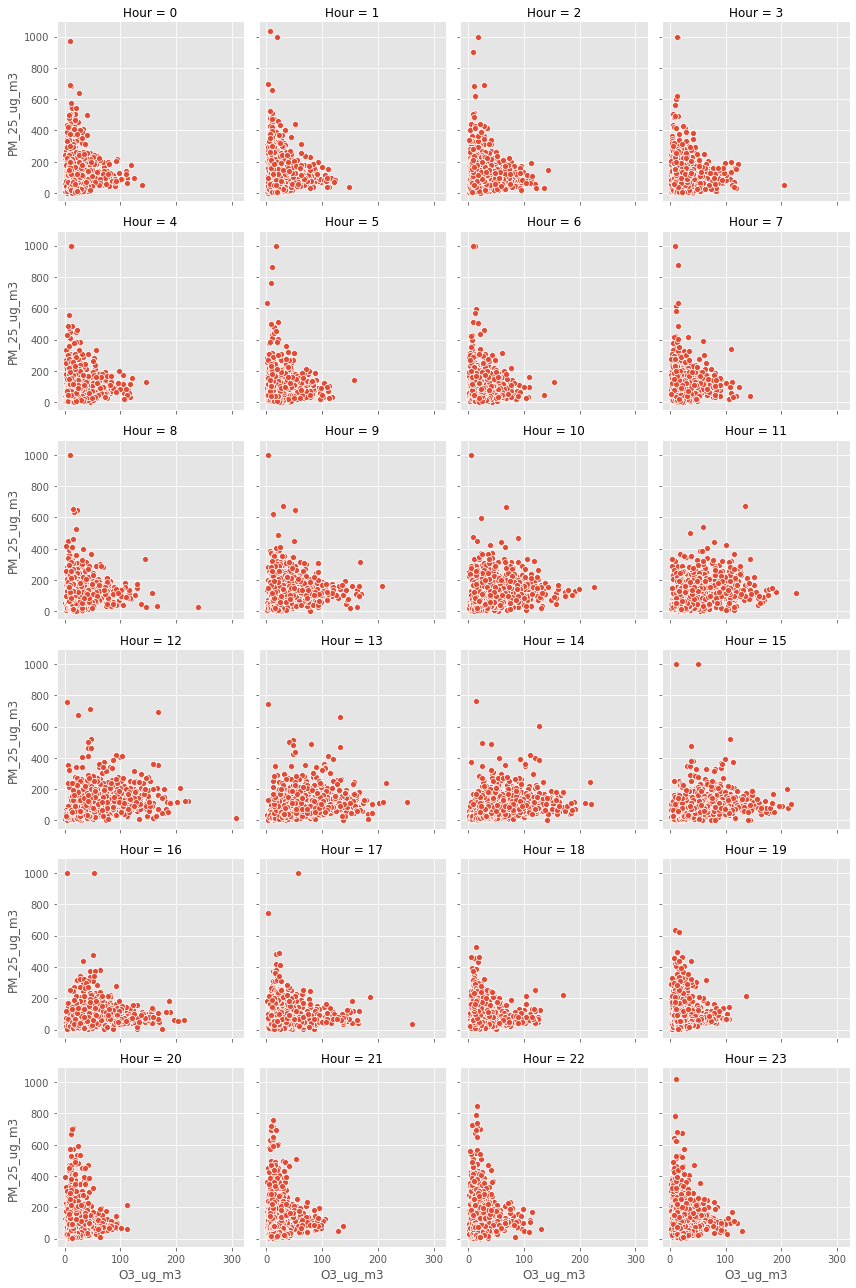

In [62]:
plots_2d(df1,x='O3_ug_m3')

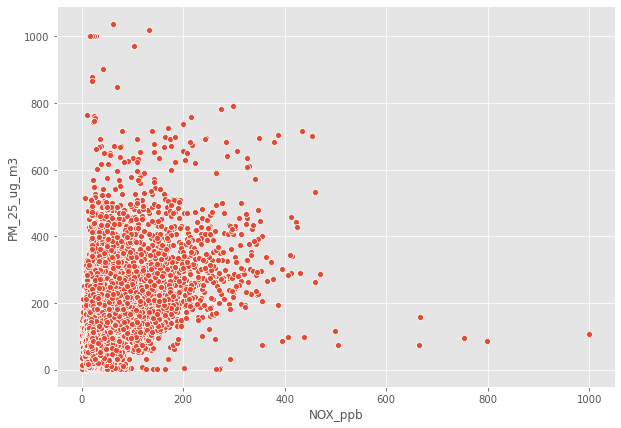

<Figure size 1080x720 with 0 Axes>

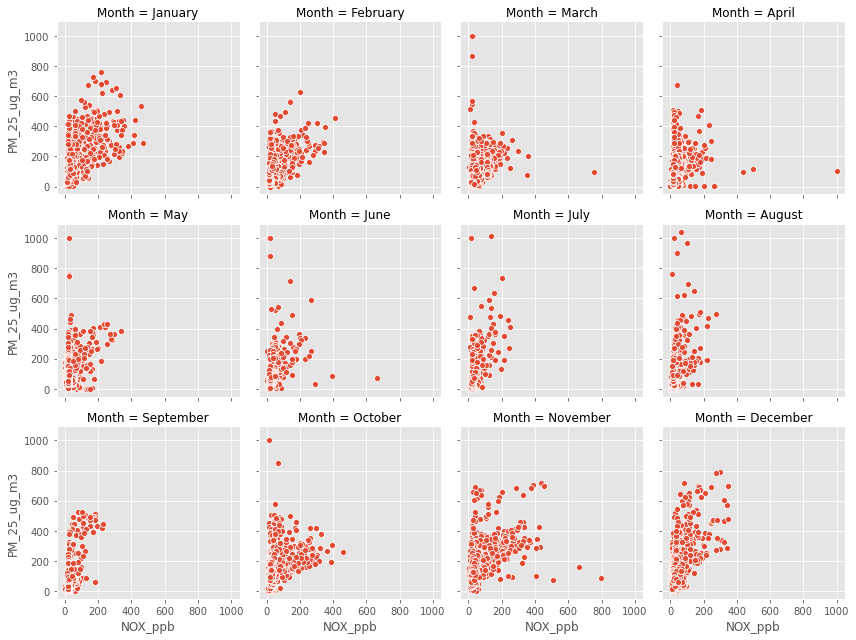

<Figure size 1080x720 with 0 Axes>

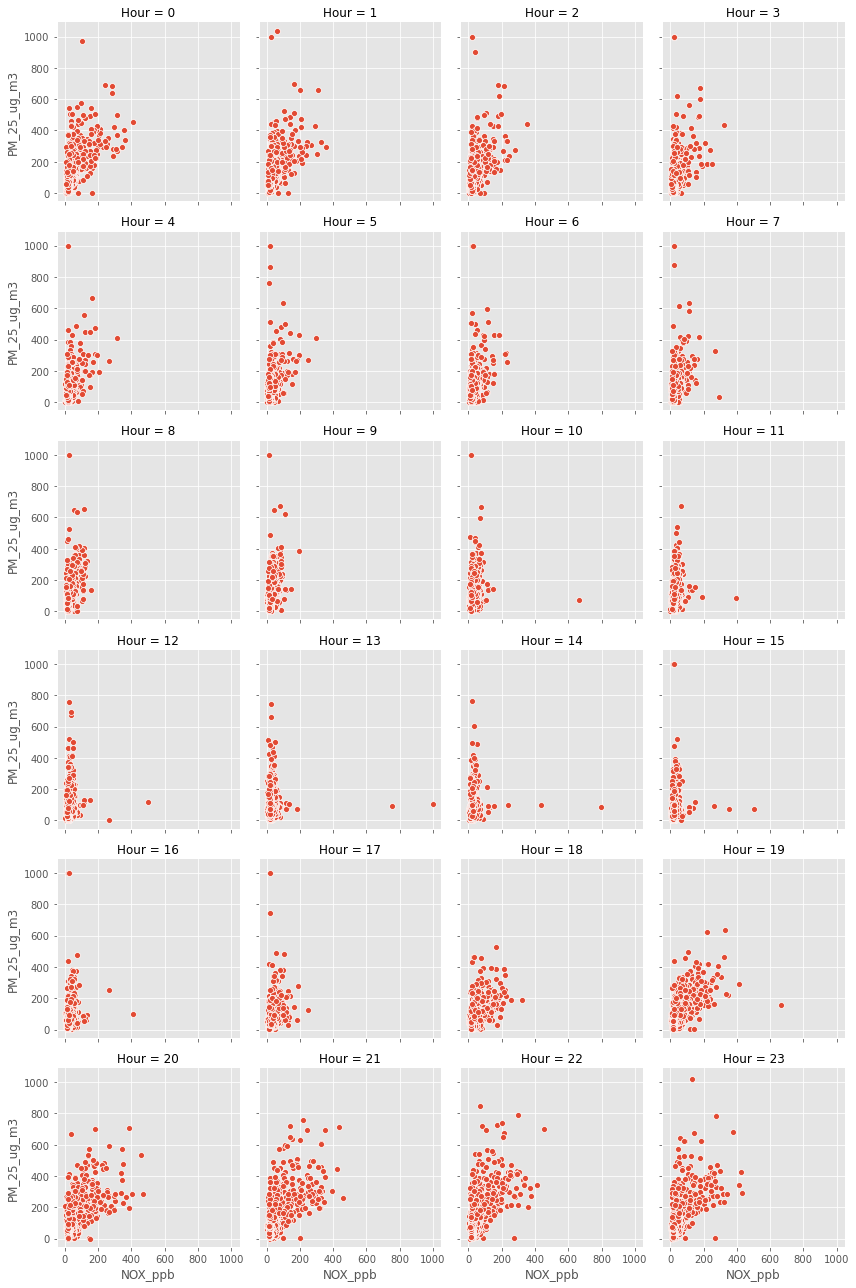

In [63]:
plots_2d(df1,x='NOX_ppb')

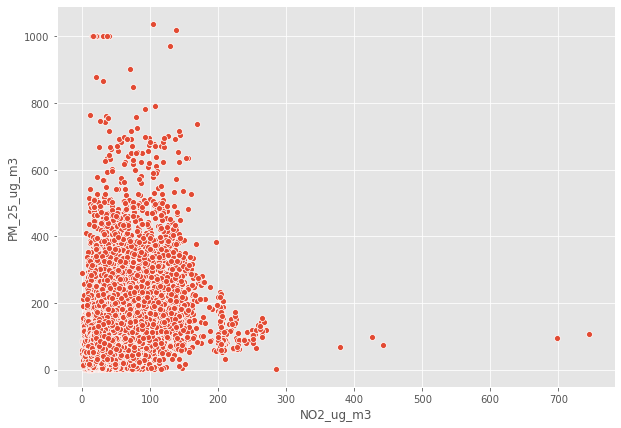

<Figure size 1080x720 with 0 Axes>

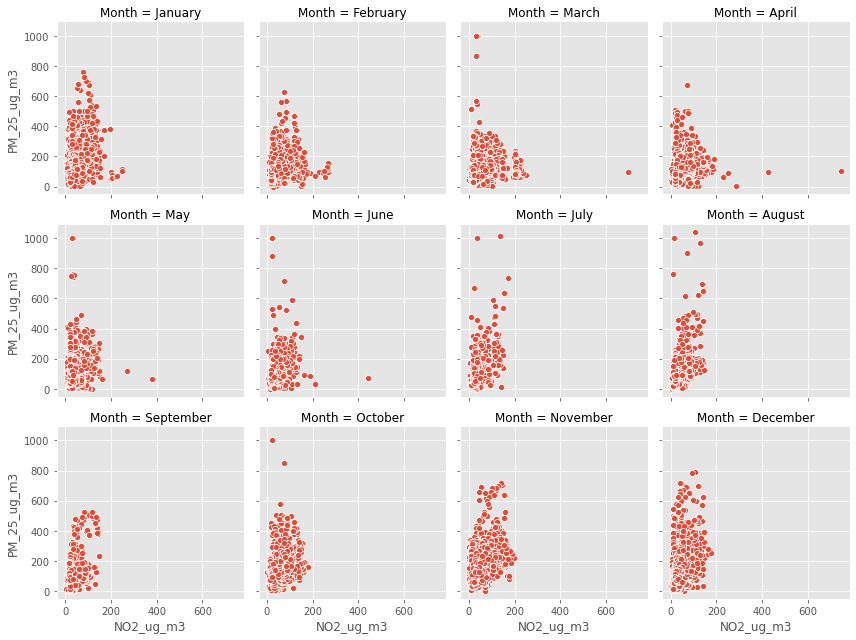

<Figure size 1080x720 with 0 Axes>

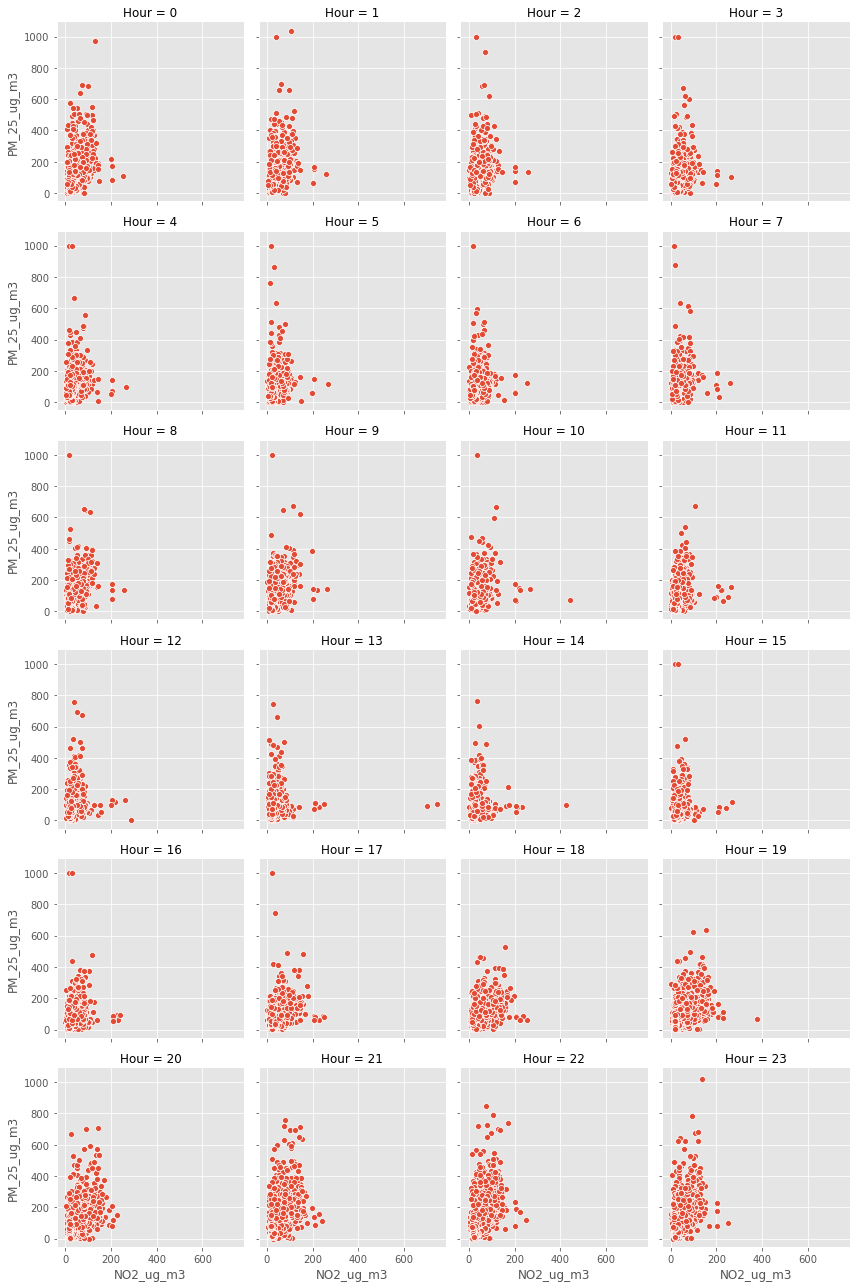

In [64]:
plots_2d(df1,x='NO2_ug_m3')

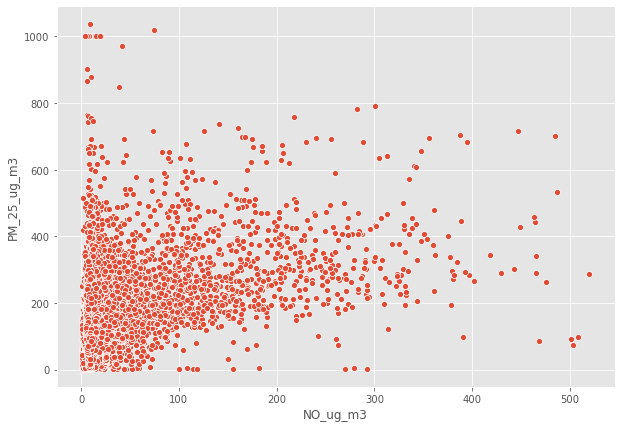

<Figure size 1080x720 with 0 Axes>

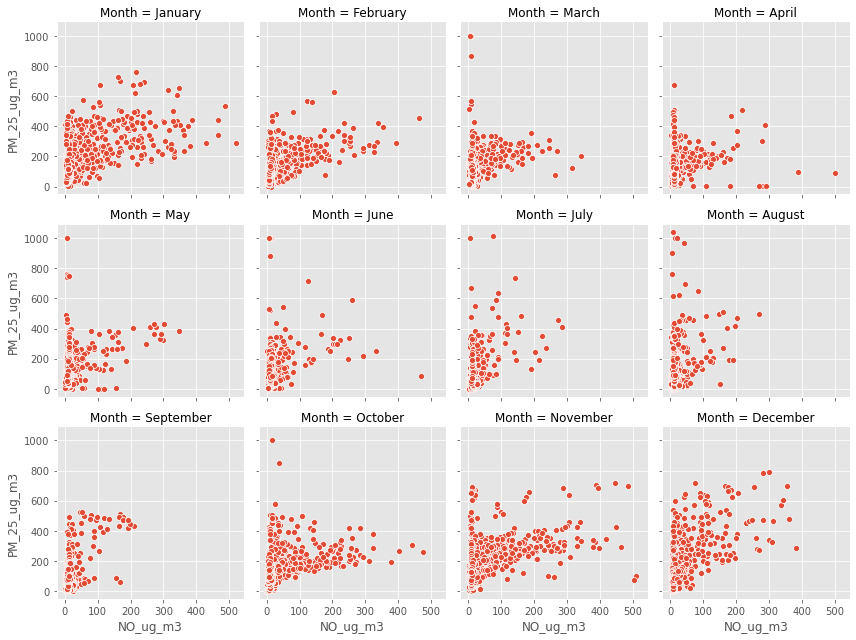

<Figure size 1080x720 with 0 Axes>

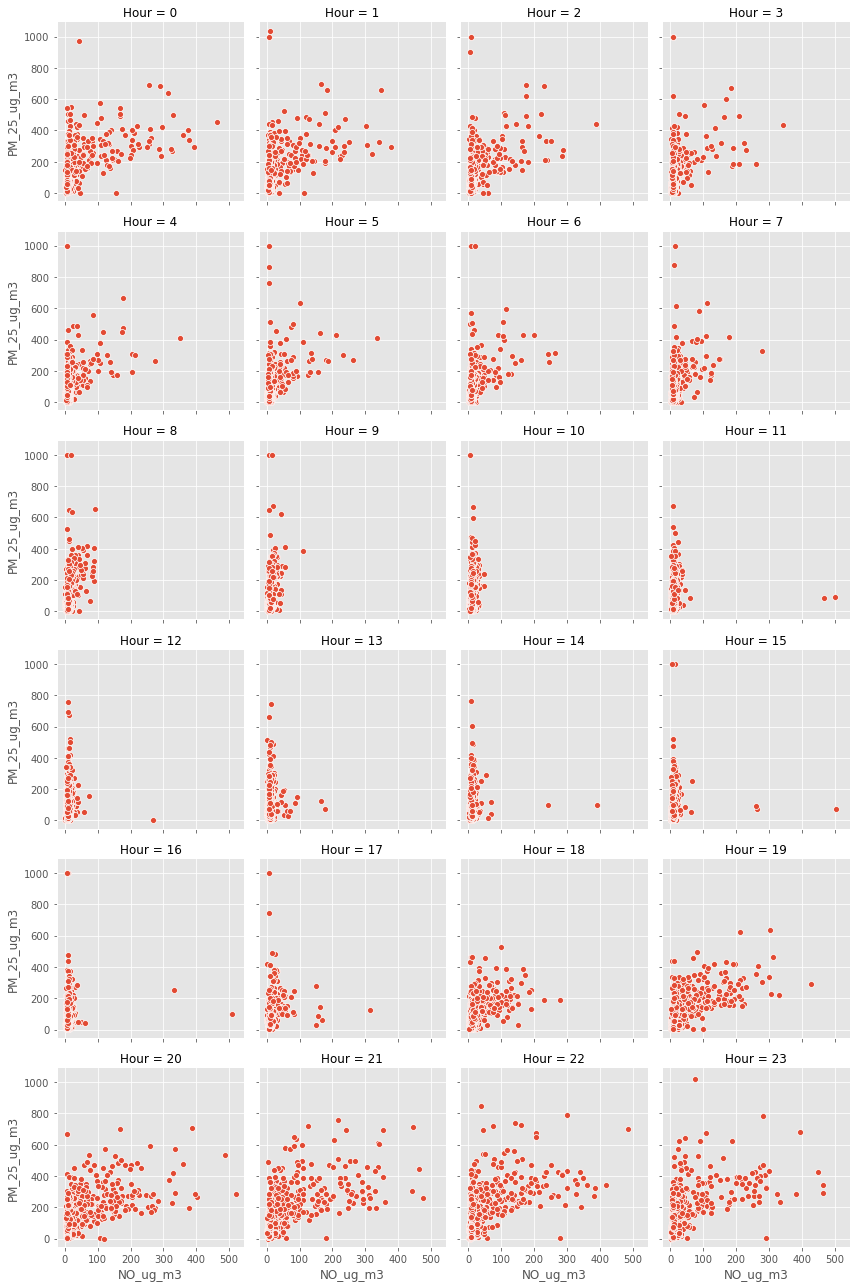

In [89]:
plots_2d(df1,x='NO_ug_m3')

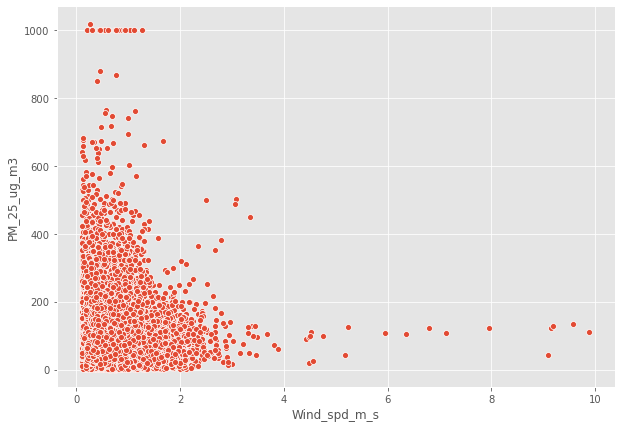

<Figure size 1080x720 with 0 Axes>

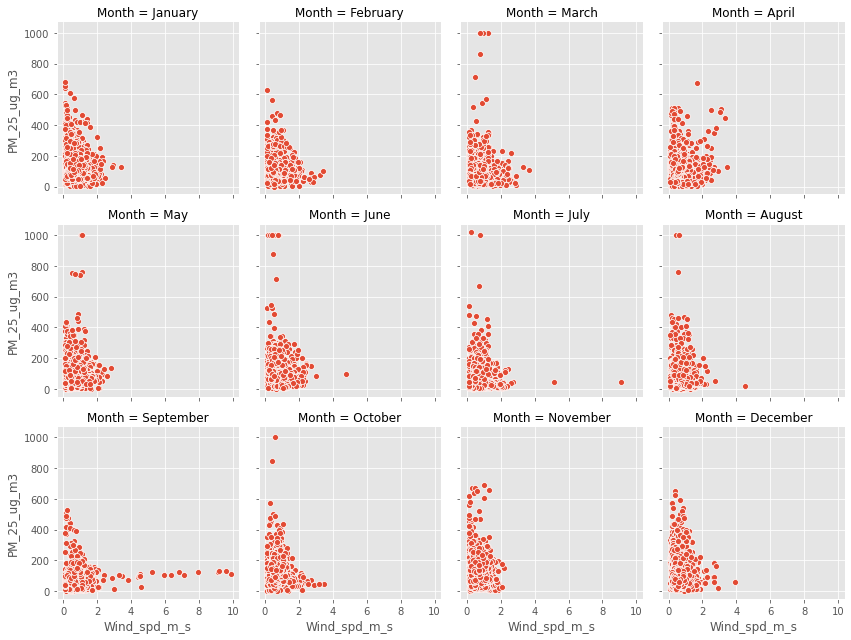

<Figure size 1080x720 with 0 Axes>

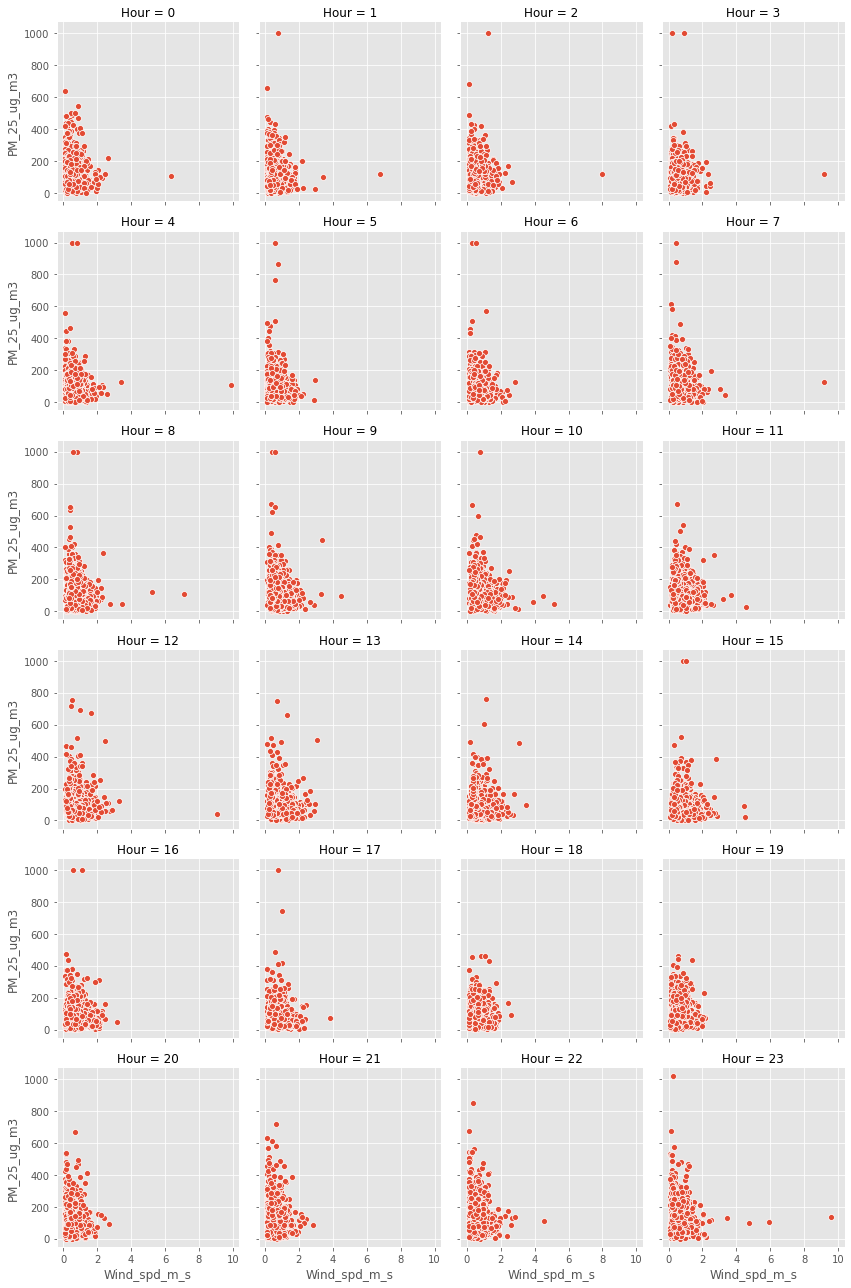

In [66]:
plots_2d(df1,x='Wind_spd_m_s')

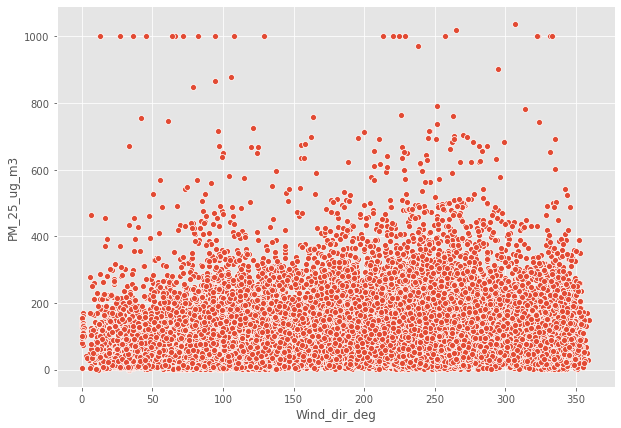

<Figure size 1080x720 with 0 Axes>

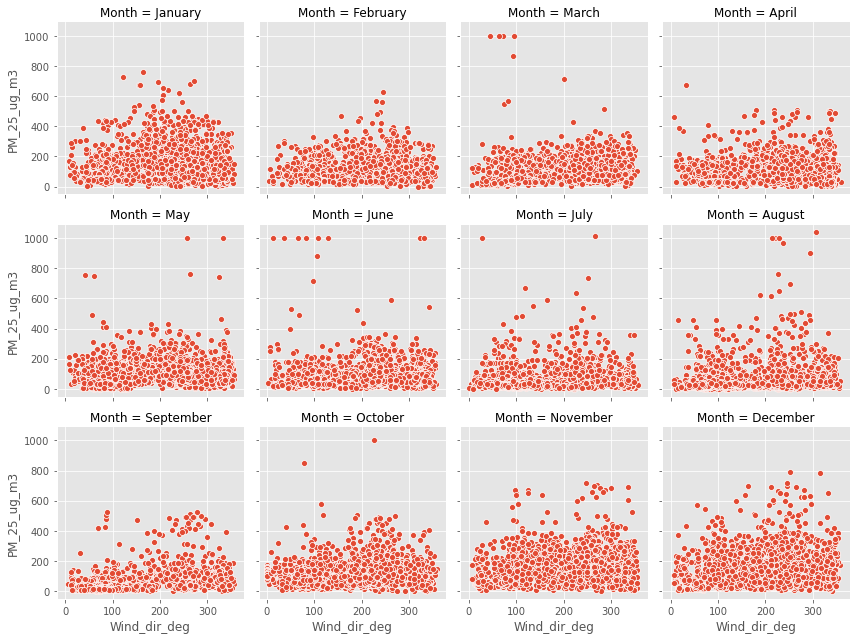

<Figure size 1080x720 with 0 Axes>

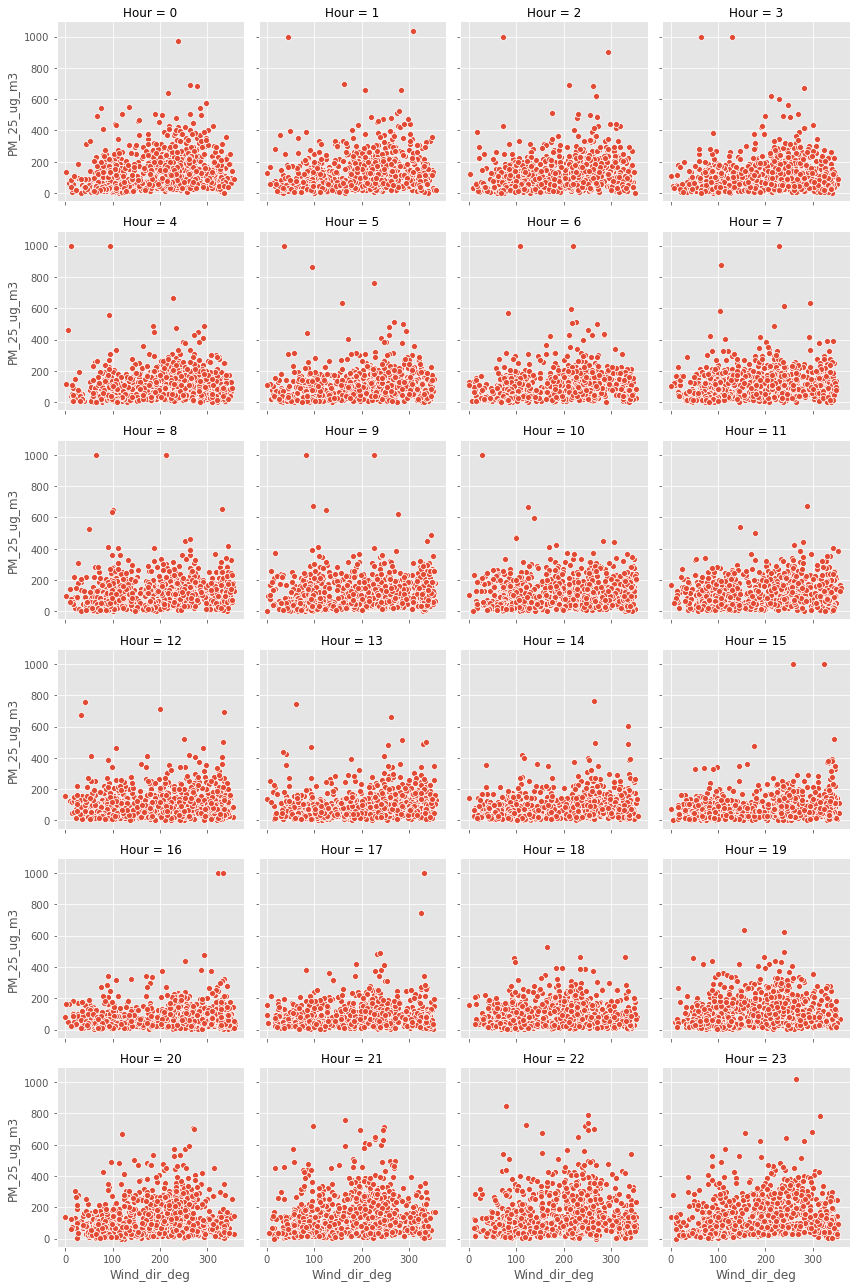

In [67]:
plots_2d(df1,x='Wind_dir_deg')

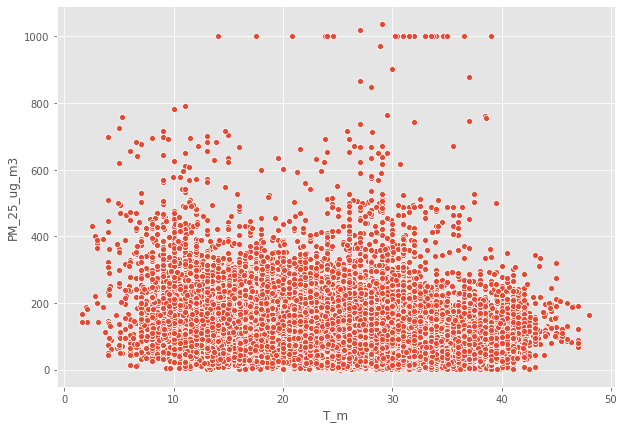

<Figure size 1080x720 with 0 Axes>

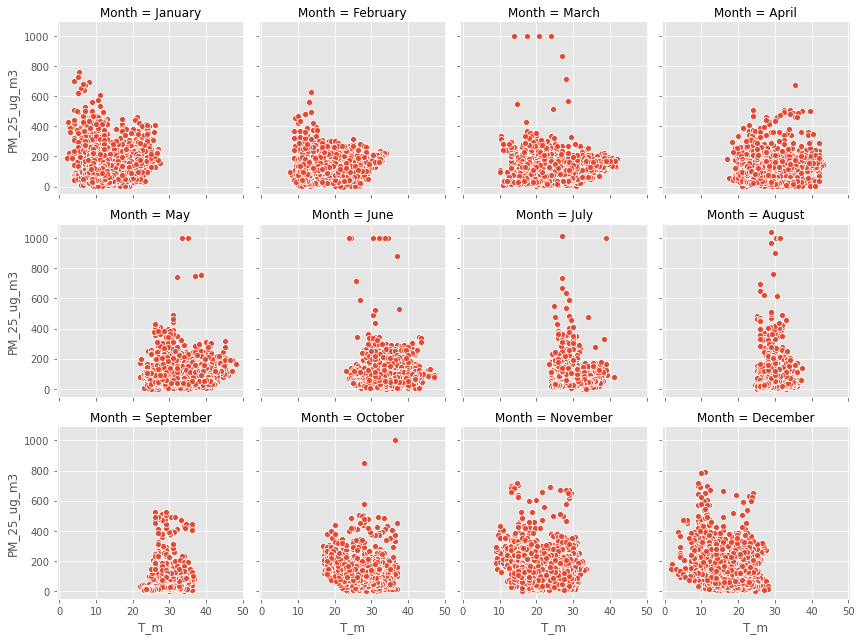

<Figure size 1080x720 with 0 Axes>

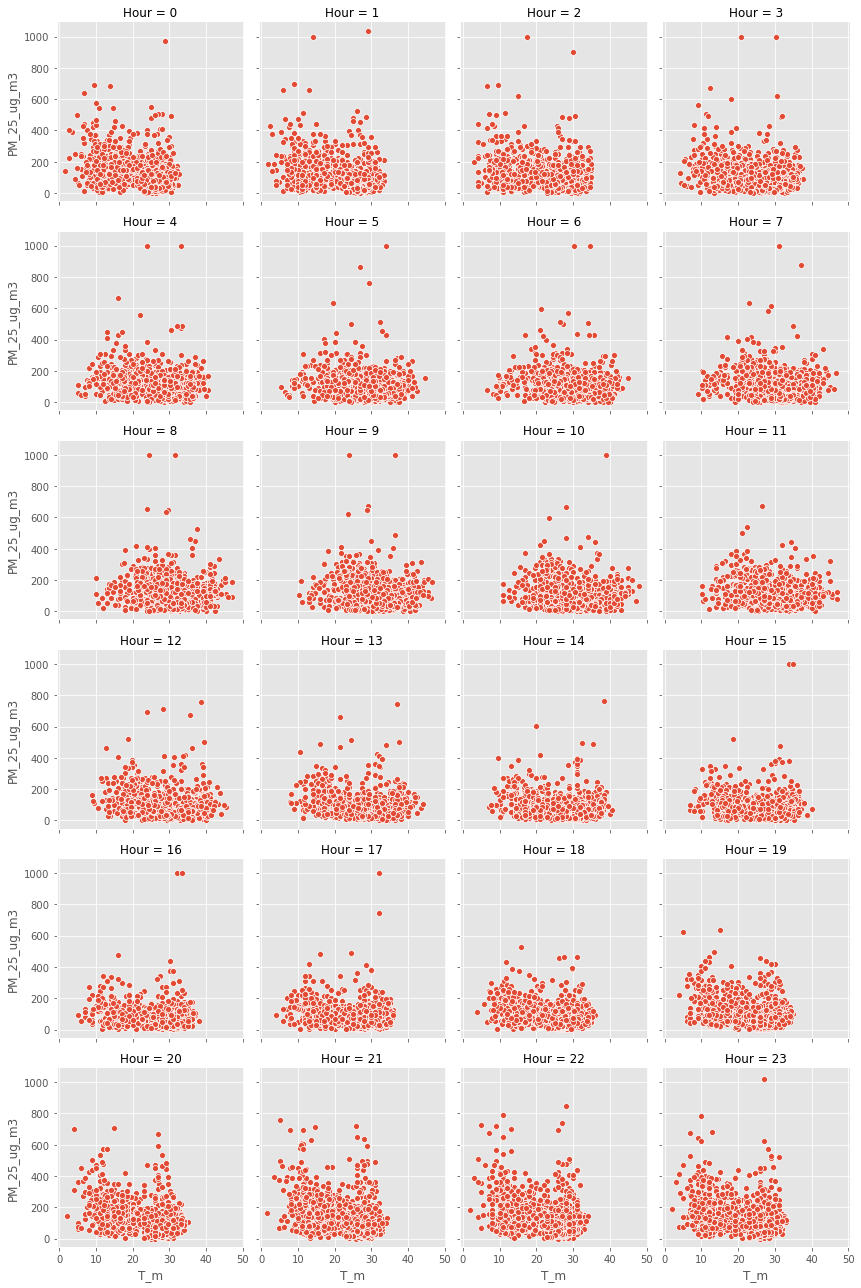

In [68]:
plots_2d(df1,x='T_m')

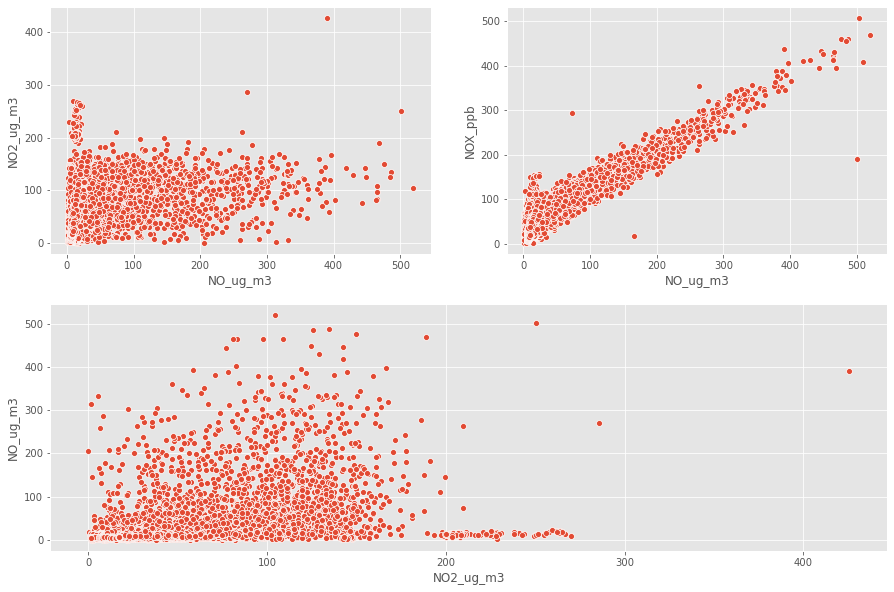

In [69]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(gs[0,0])
sns.scatterplot('NO_ug_m3','NO2_ug_m3',data=df1);
ax2 = fig.add_subplot(gs[0,1])
sns.scatterplot('NO_ug_m3','NOX_ppb',data=df1);
ax3 = fig.add_subplot(gs[1,:])
sns.scatterplot('NO2_ug_m3','NO_ug_m3',data=df1);

SO2 values tend to increase over the winter months (Nov-Dec) and tend to drop during the summer and monsoon period
<br>CO shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>NOX shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>NO shows a moderate positive trend with PM2.5 as seen in all the scatterplots.
<br>Wind speed shows a negative trend the PM 2.5 values. Few datapoints associated with high wind speeds (most of the high speed points during September) could be outliers but have been kept in the data and will be log transformed later during modeling.
<br>Temperature shows a slight negative trend with PM2.5 values. Winter months also show a slight uptick in PM values with drop in temperature
<br>The nitrogen compounds are correlated as seen. These could be decomposed as 1-2 features applying PCA or can be dropped during modeling as well. <br> The strongest linear correlation is seen between NOX and NO

In [69]:
df1.describe()

PM_25_ug_m3     SO2_ug_m3      O3_ug_m3      CO_mg_m3       NOX_ppb  \
count  22771.000000  22554.000000  22709.000000  22796.000000  22555.000000   
mean     113.994796      7.204229     34.812659      1.259228     38.024548   
std       95.411087      7.145177     32.273082      1.042414     40.843307   
min        0.010000      0.010000      1.020000      0.010000      1.060000   
25%       47.965000      3.540000     12.250000      0.650000     19.310000   
50%       90.950000      5.570000     24.060000      1.010000     25.950000   
75%      151.195000      8.980000     46.060000      1.530000     40.690000   
max     1038.500000    295.650000    306.980000     10.000000    999.990000   

          NO2_ug_m3      NO_ug_m3  Wind_spd_m_s  Wind_dir_deg  Solar_R_W_m2  \
count  22552.000000  22498.000000  18726.000000  22758.000000  22851.000000   
mean      43.456825     18.610433      0.732364    196.091990     65.758424   
std       32.999854     36.762339      0.486056     91.556869    100.174727   
min        0.030000      1.010000      0.110000      0.150000      0.010000   
25%       22.550000      7.550000      0.390000    108.000000      2.300000   
50%       33.030000     10.000000      0.650000    215.330000     23.470000   
75%       53.682500     13.830000      0.980000    264.860000     86.765000   
max      745.550000    519.820000      9.890000    359.400000   1032.070000   

       ...  NO_ug_m3_log  Wind_spd_m_s_log  Wind_dir_deg_log  \
count  ...  22498.000000      18726.000000      22758.000000   
mean   ...      2.538606          0.517228          5.126364   
std    ...      0.715313          0.246736          0.642442   
min    ...      0.698135          0.104360          0.139762   
25%    ...      2.145931          0.329304          4.691348   
50%    ...      2.397895          0.500775          5.376805   
75%    ...      2.696652          0.683097          5.582970   
max    ...      6.255404          2.387845          5.887215   

       Solar_R_W_m2_log       T_m_log       D_m_log          Year  \
count      22851.000000  24000.000000  23999.000000  24594.000000   
mean           2.935976      3.235866      2.868340   2017.975116   
std            1.776539      0.363234      0.442223      0.822338   
min            0.009950      0.963174     -0.703198   2017.000000   
25%            1.193922      3.056239      2.565718   2017.000000   
50%            3.197448      3.348500      2.944965   2018.000000   
75%            4.474663      3.481548      3.258481   2019.000000   
max            6.940290      3.892228      3.555777   2020.000000   

           Month_No   Day_of_Week          Hour  
count  24594.000000  24594.000000  24594.000000  
mean       6.455192      2.996219     11.499553  
std        3.389388      1.997341      6.916586  
min        1.000000      0.000000      0.000000  
25%        4.000000      1.000000      6.000000  
50%        6.000000      3.000000     12.000000  
75%        9.000000      5.000000     17.000000  
max       12.000000      6.000000     23.000000  

[8 rows x 30 columns]

Cyclical features can be transformed into two components (sine and cosine). This will help to emphasize that 23:00 and 0:00 hours are close to each other similar to months.

In [70]:
#Cyclical feature transformation into sine and cosine components
#Ref: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning
def cyclic_feat(df):
    #Month Cyclicity
    df['Month_sin'] = np.sin(df.Month_No*(2*np.pi/12))
    df['Month_cos'] = np.cos(df.Month_No*(2*np.pi/12))
    #Day Cyclicity
    df['Day_of_Week_sin'] = np.sin(df.Day_of_Week*(2*np.pi/7))
    df['Day_of_Week_cos'] = np.cos(df.Day_of_Week*(2*np.pi/7))
    #Hour Cyclicity
    df['Hour_sin'] = np.sin(df.Hour*(2*np.pi/24))
    df['Hour_cos'] = np.cos(df.Hour*(2*np.pi/24))
    #Wind Direction Cyclicity
    df['Wind_dir_sin'] = np.sin(df1.Wind_dir_deg*(2*np.pi/360))
    df['Wind_dir_cos'] = np.cos(df1.Wind_dir_deg*(2*np.pi/360))
    
    return df

# Check time cyclical encoding
def cyclical(x,y,annot):
    xy = list(zip(x,y))
    xy_dict = dict(zip(annot,xy))
    plt.figure(figsize=[10,10])
    plt.scatter(x,y)
    for a,b in xy_dict.items():
        #print(a,b)
        plt.annotate(str(a),(b[0],b[1]),fontsize=15)

#sns.scatterplot(x='Wind_dir_deg',y='Wind_dir_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Wind_dir_deg',y='Wind_dir_sin',data=df1,label='Sine',color='r')
#sns.scatterplot(x='Hour',y='Hour_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Hour',y='Hour_sin',data=df1,label='Sine',color='r')
#plt.figure(figsize=[5,5])
#sns.scatterplot(x='Day_No',y='Day_cos',data=df1,label='Cos',color='b')
#sns.scatterplot(x='Day_No',y='Day_sin',data=df1,label='Sine',color='r')

In [71]:
df1.equals(df1_1H)

False

In [72]:
df1 = cyclic_feat(df1)
df1_1H = cyclic_feat(df1_1H)

In [73]:
df1.equals(df1_1H)

False

In [74]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [75]:
df1_1H.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [76]:
df1.columns.equals(df1_1H.columns)

True

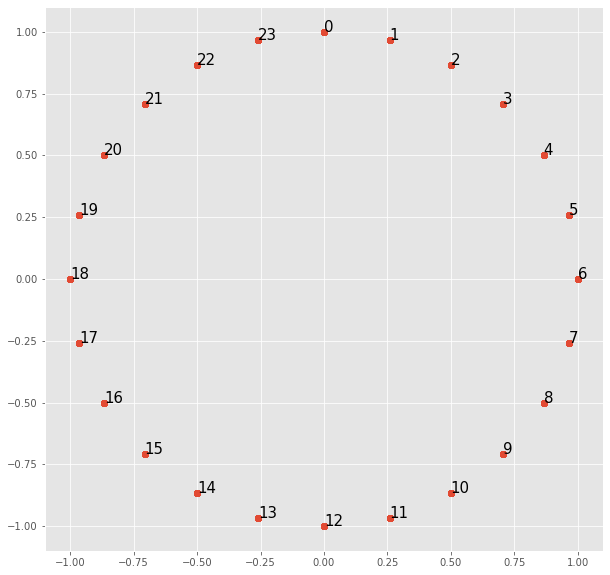

In [77]:
cyclical(df1['Hour_sin'],df1['Hour_cos'],df1['Hour'])

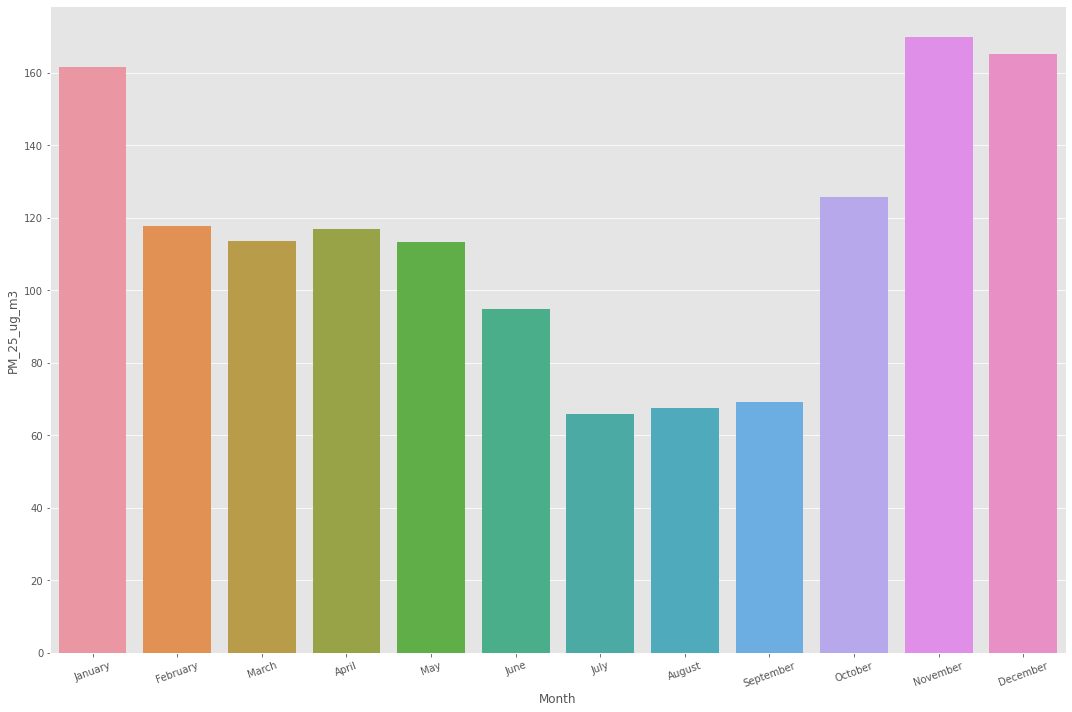

In [78]:
plt.figure(figsize=(15,10))
mth = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.barplot(x='Month',y='PM_25_ug_m3',data=df1.groupby('Month').mean().reset_index(),order=mth)
plt.xticks(rotation=20);
plt.tight_layout()

As seen, seasonality seems to affect PM2.5 values with higher values during winter and progressive drop over the summer and monsoon months

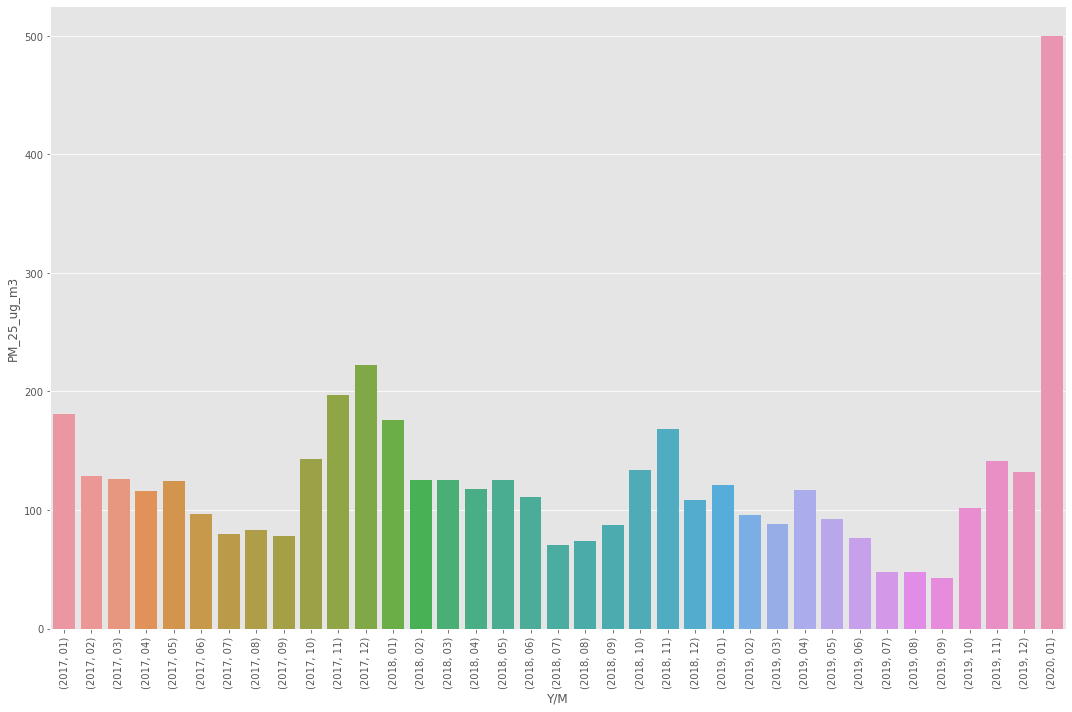

In [79]:
df1.groupby('Y/M').mean().reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x='Y/M',y='PM_25_ug_m3',data=df1.groupby('Y/M').mean().reset_index())
plt.xticks(rotation=90);
plt.tight_layout()

Month effects as seen in the two plots above show high PM values during winter months (Oct-January), drop during summer and are in their lowest range during the monsoon season.

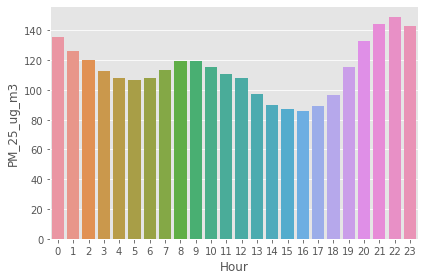

In [80]:
sns.barplot(x='Hour',y='PM_25_ug_m3',data=df1.groupby('Hour').mean().reset_index())
plt.xticks(rotation=0);
plt.tight_layout()

Time of day shows appears to correlate with the PM 2.5 values. As seen the values drop from midnight to 6 am, peak at 9 am, drop again until 4 pm and show another peak at 10 pm. 

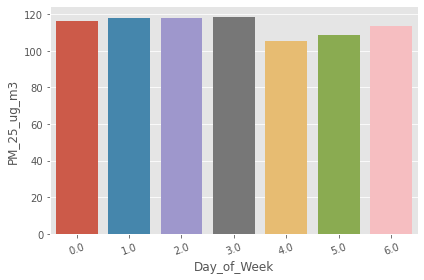

In [81]:
sns.barplot(x='Day_of_Week',y='PM_25_ug_m3',data=df1.groupby('Day').mean().reset_index())
plt.xticks(rotation=20);
plt.tight_layout()

PM 2.5 values are higher during weekdays with slight drops over Friday-Sunday

In [82]:
df1.columns

Index(['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
       'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
       'Bar_P_mmHg', 'T_m', 'D_m', 'RH_NOAA_augroch', 'PM_25_ug_m3_log',
       'SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
       'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
       'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Year', 'Month_No',
       'Day_of_Week', 'Hour', 'Day', 'Month', 'Y/M', 'Month_sin', 'Month_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
       'Wind_dir_sin', 'Wind_dir_cos'],
      dtype='object')

In [83]:
list1 = ['PM_25_ug_m3_log','SO2_ug_m3_log','O3_ug_m3_log','CO_mg_m3_log','NOX_ppb_log','NO2_ug_m3_log',
         'NO_ug_m3_log','Wind_spd_m_s_log','Solar_R_W_m2_log','T_m_log','D_m_log','Month_sin', 
         'Month_cos','Day_sin','Day_cos', 'Hour_sin', 'Hour_cos', 'Wind_dir_sin', 'Wind_dir_cos','Bar_P_mmHg']

list2 = ['PM_25_ug_m3_log','SO2_ug_m3_log','O3_ug_m3_log','CO_mg_m3_log','NO_ug_m3_log','Wind_spd_m_s_log',
         'T_m_log','D_m_log','Year','Month_sin', 'Month_cos','Day_of_Week_sin','Day_of_Week_cos', 'Hour_sin', 
         'Hour_cos','Wind_dir_sin', 'Wind_dir_cos','Bar_P_mmHg']

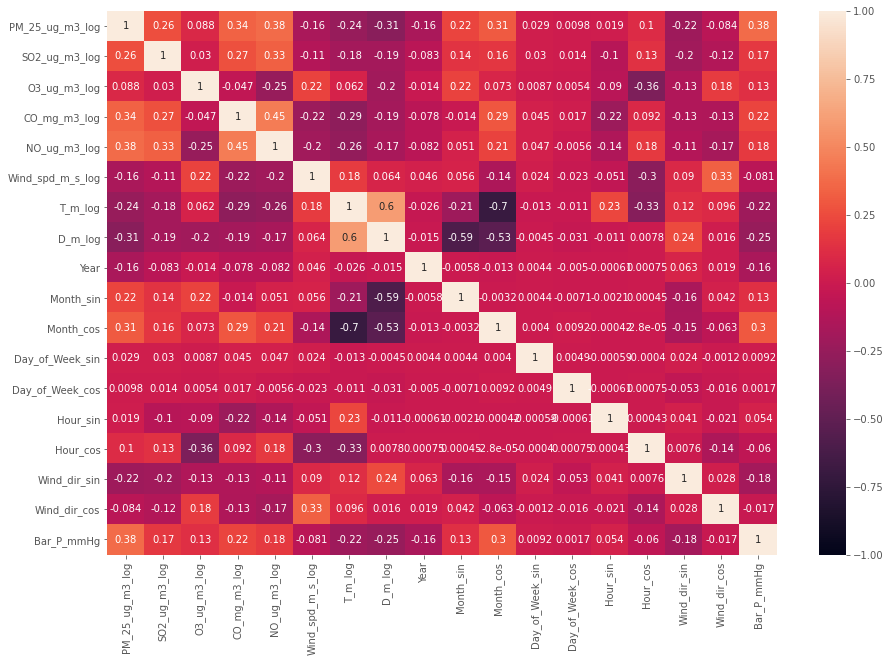

In [84]:
plt.figure(figsize=[15,10])
sns.heatmap(df1[list2].corr(),annot=True,vmin=-1,vmax=+1);

PM2.5 slightly negatively correlated with Wind Speed, ambient and dew temparatures
<br>PM2.5 shows positive correlation with other pollutants SO2, CO, NOx, NO2, NO
<br>There appears high multi-collinearity between the nitrogen compounds (NOX_ppb, NO2_ug_m3 & NO_ug_m3). All but one of these features can be dropped during modeling.
<br> O3_ug_m3 and Solar radiation do not show a strong correlation with the PM values and could be dropped during modeling
<br>

In [598]:
# plt.figure(figsize=[15,15])
# xcols1 = [a for a in log_cols if a!='PM_25_ug_m3_log']
# xcols2 = [a for a in log_cols if a!='PM_25_ug_m3']
# for i in range(1,20):
#     #print(i)
#     plt.subplot(5,4,i)
#     sns.scatterplot(df1[xcols2[i-1]],df1['PM_25_ug_m3'])
# plt.tight_layout()

In [87]:
df1.isnull().any(axis=1).sum()
df1.shape

(24594, 41)

For model creation,

The rows with missing PM_25_ug_m3 values will be dropped.

Initially a case study comparing random split vs time based split will be compared with and witout lag features.

Post that, various model performances will be compared for test RMSE using nested cross-validation to tune relevant hyper-parameters.

Finally, one step walk forward validation will be applied to get hourly predictions and again average test RMSE will be compared across models.
    
Missing Value Imputation: Mean imputation will be used to impute missing values.

Define a function to add lag variables to the dataframe

In [107]:
#Define lag function
def add_lags(df,target,rolling,w,periods=3):
    for a in df.columns:
        for b in range(periods):
            df[a+'_(H-'+str(b+1)+')'] = df[a].shift(b+1)
    df = df.copy()
    if rolling == True:
        df[target+'_roll'] = df[target].rolling(window=w).mean().shift()
        #print(w)
        #Drop previous rows (# of periods or window whichever is larger)
        df = df.iloc[max(periods,w):]
    else:
        #Drop previous rows (# of periods)
        df = df.iloc[periods:]
    #df = df.dropna()
    return df

In [599]:
#Nested Cross Validation with Multiple Train Test splits

def mod_eval(df,target,cols,splits,params,mod,time=True,
             lags=True,periods=2,rolling=True,w=2):
    
    #Drop missing values for the target variable
    df_l = df[~df[target].isna()]
    
    #Define number of splits for time series is split by time
    if time==True:
        ts_sp = TimeSeriesSplit(n_splits=splits)
        
    #Random split with Kfold if splitting randomly
    else:
        ts_sp = KFold(n_splits=splits)
    #Add lag variables if specified. A rolling mean of the last two values is added by default as a feature
    if lags == True:
        print('Lags: ',str(periods))
        df_l = add_lags(df_l[cols].sort_index().copy(),target,rolling,w,periods)
    else:
        df_l = df_l[cols]
    #df_l = df_l[opt_cols].sort_index()
    
    #Initialize lists to collect results and metric data for test/train datasets
    results = pd.DataFrame()
    test_data = []
    test_pred_data = []
    train_rmse = []
    train_mae = []
    test_rmse = []
    test_mae = []
    i = 1
    #Loop through total # of splits specified
    for tr_i, te_i in ts_sp.split(df_l):
        print('Split '+str(i))
        #Split data as train and test components based on Kfold or TimeSeriesSplit
        train = df_l.iloc[tr_i]
        test = df_l.iloc[te_i]

        #Record time index and columns
        tr_ind = train.index
        te_ind = test.index
        tr_cl = train.columns
        te_cl = test.columns
        
        #Split into X & y components
        X_train = train.drop([target],axis=1)
        y_train = train[target]
        X_test = test.drop([target],axis=1)
        y_test = test[target]

#         #Set gridsearch parameters
#         params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
#                   'mod__num_leaves':[10,31,50]}

        #Pipeline object to impute, scale and fit model
        pipeline = Pipeline([('imp',SimpleImputer(strategy='mean')),('scl',StandardScaler()),
                             ('mod',mod)])

        #Define gridsearch object for hyper-parameter tuning by splitting training data into train & validation sets
        grid = GridSearchCV(pipeline,param_grid=params,cv=ts_sp,
                            scoring='neg_mean_squared_error')

        #Fit gridsearch object on X_train, y_train
        grid.fit(X_train,y_train)
        y_train_pred = grid.predict(X_train)
        y_test_pred = grid.predict(X_test)
        print('Finished grid search for '+'split '+str(i))
            
        #Append all results to a dataframe

        tr = pd.DataFrame(y_train).set_index(tr_ind).rename(columns={target:'Train_'+str(i)})
        tr_pred = pd.DataFrame(y_train_pred).set_index(tr_ind).rename(columns={0:'Train_pred_'+str(i)})
        te = pd.DataFrame(y_test).set_index(te_ind).rename(columns={target:'Test_'+str(i)})
        te_pred = pd.DataFrame(y_test_pred).set_index(te_ind).rename(columns={0:'Test_pred_'+str(i)})
        results = pd.concat([results,tr,tr_pred,te,te_pred],axis=1)

        train_mae.append(mae(y_train,y_train_pred))
        test_mae.append(mae(y_test,y_test_pred))
        train_rmse.append(np.sqrt(mse(y_train,y_train_pred)))
        test_rmse.append(np.sqrt(mse(y_test,y_test_pred)))

        print('Split:',str(i),':',grid.best_params_)
        i+=1

    print('Average Train MAE: ',np.mean(train_mae),' Average Train RMSE: ',np.mean(train_rmse))
    print('Average Test MAE: ',np.mean(test_mae),' Average Test RMSE: ',np.mean(test_rmse))
    return results,train_rmse,test_rmse,train_mae,test_mae

Function to test walk forward validation on a random split as well as a sequential split

In [514]:
#Walk Forward Validation
def walk_forward(DF,start,end,mod,cols,periods,rolling,w,log_c=True,predictions=20,
                 random=False,test_size=0.01,plots=True):
    
    #Define data columns to be used for the walk forward training
    
    target = 'PM_25_ug_m3'
    
    if log_c == True:
        
        target = 'PM_25_ug_m3_log'
    
    df = DF[~DF[target].isna()][cols]
    
    #Specify dataset to be used for modeling
    
    data = df.loc[start:end,:].sort_index()
    #print(len(data))
    
    # Add lag variables and remove first period # of rows that get filled with null values
    data = add_lags(data.copy(),target,rolling,w,periods)
    
    if random == True:
        
        X = data.drop(target,axis=1)
        y = data[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=100)
        train = pd.concat([X_train,y_train],axis=1)
        #train['is_train'] = 1
        test = pd.concat([X_test,y_test],axis=1)
        #test['is_train'] = 0
        data = pd.concat([train,test],axis=0)
        data_time = data.index
        train_time = data.iloc[:-len(test)].index
        test_time = data.iloc[-len(test):].index
        tr = len(train)
        tot = len(data)

        print('Initial Train size: ',len(X_train),'Prediction size: ',len(X_test))
    
    else:
        data_time = data.index
        train_time = data.iloc[:-predictions].index
        test_time = data.iloc[-predictions:].index
        tot = len(data)
        tr = len(data.iloc[:-predictions])

    test_ind = []
    train_rmse = []
    test_rmse = []
    test_obs = []
    test_pred = []
    feat_imp = []
    b = 0
    print('Initial train size: ',tr,'Prediction size: ',tot-tr)
    
    for a in range(tr,tot):

        train = data.iloc[0:a]
        test = data.iloc[a:a+1]
        test_ind.append(test.index)
        
        X_train = train.drop([target],axis=1)
        X_test = test.drop([target],axis=1)
        y_train = train[target]
        y_test = test[target]
        
        #Pipeline object to impute, scale and fit model
        pipeline = Pipeline([('imp',SimpleImputer(strategy='mean')),('scl',StandardScaler()),
                             ('mod',mod)])
        
        pipeline.fit(X_train,y_train)
        
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        if log_c == True:
            y_train = (np.exp(y_train) - 1)
            y_train_pred = (np.exp(y_train_pred) - 1)
            y_test = np.exp(y_test)-1
            y_test_pred = (np.exp(y_test_pred) - 1)
        
        b = b+1
        if b%20 == 0:    
            print('Fitted',b,'/',(tot-tr),'th model')
        
        #Collect test and predicted test observations
        test_obs.append(y_test)
        test_pred.append(y_test_pred)
        
        #Calculate train and test rmse

        train_rmse.append(np.sqrt(mse(y_train,y_train_pred)))
        test_rmse.append(np.sqrt(mse(y_test,y_test_pred)))
        
        feat_imp.append(pipeline.steps[2][1].feature_importances_)
        feat_cols = X_train.columns
        
    #Append test results to a dataframe
    print(len(test_obs),len(test_pred))
    t_obs = pd.DataFrame(pd.concat(test_obs)).rename(columns={target:'Test_Observed'})
    t_pred = pd.DataFrame(test_pred).rename(columns={0:'Test_Predicted'}).set_index(test_time)
    results = pd.concat([t_obs,t_pred],axis=1)
    print(' Average Test RMSE: ',np.sqrt(mse(results['Test_Observed'],results['Test_Predicted'])))
    print(' Average Train RMSE: ',np.mean(train_rmse))
    if plots == True:
            #Plots
            gs = gridspec.GridSpec(2,2)
            fig = plt.figure(figsize=(15,10))

            ax1 = fig.add_subplot(gs[0,0])
            ax1.title.set_text('Scatter plot Observed vs Predicted')
            ax1.set(xlabel='Observed PM2.5 Values',ylabel='Predicted PM2.5 Values')
            xy = np.arange(0,700)
            sns.lineplot(xy,xy,ax= ax1,color='blue')
            sns.scatterplot(results['Test_Observed'],results['Test_Predicted'],ax=ax1)
            
            ax2 = fig.add_subplot(gs[0,1])
            ax2.title.set_text('Mean Feature Importance Plot')
            feat = pd.DataFrame(feat_imp)
            feat.columns = feat_cols
            means = [feat[a].mean() for a in feat.columns]
            cols = [a for a in feat.columns]
            imp = pd.DataFrame(means,feat.columns).reset_index().rename(columns={'index':'Features',0:'Feature_Importances'})
            sns.barplot(x='Feature_Importances',y='Features',data=imp.nlargest(15,'Feature_Importances'),ax=ax2)    
            
            ax3 = fig.add_subplot(gs[1,:])
            ax3.title.set_text('Observed V Predicted (Test Values)')
            sns.lineplot(data=results,ax=ax3)
            plt.tight_layout()
    
    return results

In [410]:
n_cols = ['PM_25_ug_m3', 'SO2_ug_m3', 'O3_ug_m3', 'CO_mg_m3', 'NOX_ppb',
           'NO2_ug_m3', 'NO_ug_m3', 'Wind_spd_m_s', 'Wind_dir_deg', 'Solar_R_W_m2',
           'Bar_P_mmHg', 'T_m', 'D_m', 'Year', 'Month_sin', 'Month_cos',
           'Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_sin', 'Hour_cos',
           'Wind_dir_sin', 'Wind_dir_cos']
    
log_cols = ['PM_25_ug_m3_log','SO2_ug_m3_log', 'O3_ug_m3_log', 'CO_mg_m3_log', 'NOX_ppb_log',
            'NO2_ug_m3_log', 'NO_ug_m3_log', 'Wind_spd_m_s_log', 'Wind_dir_deg_log',
            'Solar_R_W_m2_log', 'T_m_log', 'D_m_log', 'Month_sin', 'Month_cos','Day_of_Week_sin',
            'Day_of_Week_cos', 'Hour_sin', 'Hour_cos','Wind_dir_sin', 'Wind_dir_cos']

opt_cols = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
            'Day_of_Week_cos','Hour_sin','Hour_cos']
opt_cols_1 = ['PM_25_ug_m3','Month_sin','Month_cos','Day_of_Week_sin',
              'Day_of_Week_cos','Hour_sin','Hour_cos','T_m','D_m', 
              'Wind_spd_m_s','Wind_dir_sin', 'Wind_dir_cos']

Case1: Random Split / No lag variables / Use original non-log features

In [411]:
mod = LGBMRegressor()
params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
          'mod__num_leaves':[10,31,50]}

res_c1,tr_rmse_c1,te_rmse_c1,tr_mae_c1,te_mae_c1 = mod_eval(df1,'PM_25_ug_m3',cols=n_cols,splits=3,
                                             time=False,lags=False,params=params,mod=mod,periods=1)

Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train MAE:  36.77561651827699  Average Train RMSE:  59.279259826123585
Average Test MAE:  47.9303630983568  Average Test RMSE:  72.17573351318997


This model yields an RMSE of 72 and appears to be overfitting with an average train RMSE of 59. Next, consider a time based split without lags.

<br>Case2: Time based Split / No lag variables / Use original non-log features

In [412]:
mod = LGBMRegressor()
params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
          'mod__num_leaves':[10,31,50]}

res_c2,tr_rmse_c2,te_rmse_c2,tr_mae_c2,te_mae_c2 = mod_eval(df1,'PM_25_ug_m3',cols=n_cols,splits=3,
                                             time=True,lags=False,params=params,mod=mod,periods=1)

Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.005, 'mod__n_estimators': 200, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train MAE:  40.4940855895175  Average Train RMSE:  67.93515001008014
Average Test MAE:  59.16595202622625  Average Test RMSE:  83.21742683127604


This model with time based split has a worse average RMSE of ~83 compared to the previous case based on random splitting. As before, the model appears to be overfitting with a lower average train RMSE.

It is possible that with random splitting in case 1, future data is being used to predict past values and might be contributing to a lower RMSE than Case 1.

<br> Case3: Random Split / 3 lag variables / Use original non-log features

In [413]:
mod = LGBMRegressor()
params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
          'mod__num_leaves':[10,31,50]}

res_c3,tr_rmse_c3,te_rmse_c3,tr_mae_c3,te_mae_c3 = mod_eval(df1,'PM_25_ug_m3',cols=n_cols,splits=3,
                                             time=False,lags=True,params=params,mod=mod,periods=3)

Lags:  3
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.1, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 200, 'mod__num_leaves': 10}
Average Train MAE:  13.695050262584475  Average Train RMSE:  28.661396686386666
Average Test MAE:  16.339356688567857  Average Test RMSE:  36.890243761743456


This shows an improved performance compared to a random split without lag variables. Test RMSE is higher than train RMSE but not as severe as in case 2.

<br> Case4: Time based Split / 3 lag variables / Use original non-log features

In [414]:
mod = LGBMRegressor()
params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
          'mod__num_leaves':[10,31,50]}

res_c4,tr_rmse_c4,te_rmse_c4,tr_mae_c4,te_mae_c4 = mod_eval(df1,'PM_25_ug_m3',cols=n_cols,splits=3,
                                             lags=True,params=params,mod=mod,periods=3)

Lags:  3
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 31}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 31}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train MAE:  14.0724931852638  Average Train RMSE:  30.916094507595883
Average Test MAE:  16.954309695607463  Average Test RMSE:  33.873450031568304


The test RMSE values are slightly better in this case compared  to case 3.

Random split without lags shows a better RMSE compared to time based split without lags. Both cases show large differences between train and test RMSE.

With lags, the RMSE performances are similar between random and time split with the latter having a slightly better RMSE.

For the case studies above, all columns were used in the model. All test next will be based on time split and will sequentially check usefulness of features in model prediction.

Next, consider using only lag features for PM_25_ug_m3 to check model performance.

In [415]:
for a in range(1,6):
    print('Lag Features: ',str(a))
    mod = LGBMRegressor()
    cols = ['PM_25_ug_m3']
    params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
              'mod__num_leaves':[10,31,50]}
    res_ll,tr_rmse_ll,te_rmse_ll,tr_mae_ll,te_mae_ll = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 500, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.1, 'mod__n_estimators': 200, 'mod__num_leaves': 10}
Average Train MAE:  17.92483331955234  Average Train RMSE:  42.67921159662392
Average Test MAE:  16.449266675634046  Average Test RMSE:  35.10210215992738
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train 

Higher lags do not improve test RMSE. 1-2 lags is sufficient. Next add time features to check model improvements.

In [416]:
for a in range(1,5):
    print('Lag Features: ',str(a))
    mod = LGBMRegressor()
    cols = opt_cols
    params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
              'mod__num_leaves':[10,31,50]}
    res_lo,tr_rmse_lo,te_rmse_lo,tr_mae_lo,te_mae_lo = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train MAE:  17.122641894943946  Average Train RMSE:  39.83965497234042
Average Test MAE:  16.180768685968637  Average Test RMSE:  33.73787932872231
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Trai

Slight improvement with time features. 1 lag is sufficient.

Next, add weather features to check for any RMSE changes.

In [417]:
for a in range(1,5):
    print('Lag Features: ',str(a))
    mod = LGBMRegressor()
    cols = opt_cols_1
    params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
              'mod__num_leaves':[10,31,50]}
    res_lo_1,tr_rmselo_1,te_rmselo_1,tr_maelo_1,te_maelo_1 = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train MAE:  16.756755715344  Average Train RMSE:  38.36586119312494
Average Test MAE:  16.546637852236742  Average Test RMSE:  34.31116534122543
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Train M

No significant improvement with weather features. Check with adding all other pollutant features.

In [418]:
for a in range(1,5):
    print('Lag Features: ',str(a))
    mod = LGBMRegressor()
    cols = n_cols
    params = {'mod__n_estimators':[100,200,500], 'mod__learning_rate':[0.005,0.05,0.1,0.2], 
              'mod__num_leaves':[10,31,50]}
    res_l_a,tr_rmse_l_a,te_rmse_l_a,tr_mae_l_a,te_mae_l_a = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 31}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 200, 'mod__num_leaves': 10}
Average Train MAE:  14.708684929839341  Average Train RMSE:  32.881677162070474
Average Test MAE:  17.151127014135877  Average Test RMSE:  34.258777785640774
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 50}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__n_estimators': 100, 'mod__num_leaves': 10}
Average Tr

No significant improvement using all the features. Thus 1-2 lags with time features is sufficient when using the LGBM model.

Follow similar steps with the GradientBoostingRegressor
Initially use only lags for PM_25_ug_m3 and vary between 1-4

In [419]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = GradientBoostingRegressor()
    cols = ['PM_25_ug_m3']
    params = {'mod__n_estimators':[100,200], 'mod__learning_rate':[0.05,0.1,0.2], 
              'mod__max_depth':[2,3,7]}
    res_gl,tr_rmse_gl,te_rmse_gl,tr_mae_gl,te_mae_gl = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 200}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__max_depth': 3, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 3, 'mod__n_estimators': 100}
Average Train MAE:  18.38841422995389  Average Train RMSE:  41.48842286774103
Average Test MAE:  17.194458728064923  Average Test RMSE:  36.21943256792762
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.2, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.1, 'mod__max_depth': 3, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 3, 'mod__n_estimators': 100}
Average Train MAE:  17.5420

Multiple lag features do not change RMSE. One lag seems to be enough. Next, add time features

In [420]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = GradientBoostingRegressor()
    cols = opt_cols
    params = {'mod__n_estimators':[100,200], 'mod__learning_rate':[0.05,0.1,0.2], 
              'mod__max_depth':[2,3,7]}
    res_go,tr_rmse_go,te_rmse_go,tr_mae_go,te_mae_go = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.1, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Average Train MAE:  17.800888516132  Average Train RMSE:  39.95367385600026
Average Test MAE:  16.676560714827968  Average Test RMSE:  34.42475253555301
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.1, 'mod__max_depth': 2, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Average Train MAE:  17.484127

Slight reduction in RMSE. One lag is sufficient. Next, add weather features.

In [421]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = GradientBoostingRegressor()
    cols = opt_cols_1
    params = {'mod__n_estimators':[100,200], 'mod__learning_rate':[0.05,0.1,0.2], 
              'mod__max_depth':[2,3,7]}
    res_go_1,tr_rmse_go_1,te_rmse_go_1,tr_mae_go_1,te_mae_go_1 = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Average Train MAE:  18.211165471750718  Average Train RMSE:  40.84786094268891
Average Test MAE:  17.322410388712907  Average Test RMSE:  35.505735184644294
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.1, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Average Train MAE:  17.7

No significant improvement with addition of weather features. Next, run the model with all features.

In [432]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = GradientBoostingRegressor()
    cols = n_cols
    params = {'mod__n_estimators':[100,200], 'mod__learning_rate':[0.05,0.1,0.2], 
              'mod__max_depth':[2,3,7]}
    res_g_a,tr_rmse_g_a,te_rmse_g_a,tr_mae_g_a,te_mae_g_a = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Average Train MAE:  17.100304227111547  Average Train RMSE:  38.61272483822475
Average Test MAE:  17.43669054422046  Average Test RMSE:  34.96598717017576
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__learning_rate': 0.05, 'mod__max_depth': 2, 'mod__n_estimators': 200}
Average Train MAE:  16.64

No significant improvement on adding all features.
Similar to Light Gradient Boost, 1 lag alongwith time features is sufficient to reduce the RMSE.

Repeating similar steps with Random Forest, start with varying lags for PM_25_ug_m3

In [433]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = RandomForestRegressor()
    cols = ['PM_25_ug_m3']
    params = {'mod__n_estimators':[100,200], 'mod__max_depth':[5,10,50,100],
             'mod__min_samples_leaf':[1,10,50,70]}
    res_rl,tr_rmse_rl,te_rmse_rl,tr_mae_rl,te_mae_rl = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 5, 'mod__min_samples_leaf': 1, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Train MAE:  17.050740390455292  Average Train RMSE:  40.02346668980883
Average Test MAE:  16.75206017901829  Average Test RMSE:  35.75279525368
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Train MAE:

No significant improvement with increasing lags beyond 1. Next, add time features.

In [434]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = RandomForestRegressor()
    cols = opt_cols
    params = {'mod__n_estimators':[100,200], 'mod__max_depth':[5,10,50,100],
             'mod__min_samples_leaf':[1,10,50,70]}
    res_ro,tr_rmse_ro,te_rmse_ro,tr_mae_ro,te_mae_ro = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 100, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Train MAE:  14.888526800086192  Average Train RMSE:  37.78724917205057
Average Test MAE:  15.738629563798023  Average Test RMSE:  33.66570136964859
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Tra

Slight RMSE improvement. No large improvements beyond 1 lag. Next, add weather features.

In [435]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = RandomForestRegressor()
    cols = opt_cols_1
    params = {'mod__n_estimators':[100,200], 'mod__max_depth':[5,10,50,100],
             'mod__min_samples_leaf':[1,10,50,70]}
    res_ro_1,tr_rmse_ro_1,te_rmse_ro_1,tr_mae_ro_1,te_mae_ro_1 = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 100, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Train MAE:  14.217858463903127  Average Train RMSE:  36.87139674000085
Average Test MAE:  15.807588222175783  Average Test RMSE:  33.69955399288659
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 100, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Tr

No further improvements with weather features. Finally, run model with all features.

In [436]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = RandomForestRegressor()
    cols = n_cols
    params = {'mod__n_estimators':[100,200], 'mod__max_depth':[5,10,50,100],
             'mod__min_samples_leaf':[1,10,50,70]}
    res_r_a,tr_rmse_r_a,te_rmse_r_a,tr_mae_r_a,te_mae_r_a = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 100, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Train MAE:  13.061852704667096  Average Train RMSE:  34.81824268321942
Average Test MAE:  16.59179478715987  Average Test RMSE:  33.8662694258125
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__max_depth': 10, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__max_depth': 100, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__max_depth': 50, 'mod__min_samples_leaf': 10, 'mod__n_estimators': 200}
Average Trai

Using 1 lag and time features again is sufficient to minimize RMSE. 

Next,repeat similar steps with XGBoost. Starting with varying lags for PM_25_ug_m3

In [437]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = XGBRegressor()
    cols = ['PM_25_ug_m3']
    params = {'mod__gamma':[0,0.3,2],'mod__eta':[0.01,0.1,0.2], 'mod__max_depth':[2,3,7],
              'mod__min_child_weight':[1,5],'mod__n_estimators':[100,300,500]}
    res_xg_l,tr_rmse_xg_l,te_rmse_xg_l,tr_mae_xg_l,te_mae_xg_l = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.2, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 1, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_estimators': 500}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_estimators': 500}
Average Train MAE:  17.750708716025898  Average Train RMSE:  40.35751776909573
Average Test MAE:  16.898801813516553  Average Test RMSE:  36.45877372816109
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.2, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 1, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__

As seen before, a single lag is sufficient. Next, add time features

In [438]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = XGBRegressor()
    cols = opt_cols
    params = {'mod__gamma':[0,0.3,2],'mod__eta':[0.01,0.1,0.2], 'mod__max_depth':[2,3,7],
              'mod__min_child_weight':[1,5],'mod__n_estimators':[100,300,500]}
    res_xgo,tr_rmse_xgo,te_rmse_xgo,tr_mae_xgo,te_mae_xgo = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_estimators': 100}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_estimators': 500}
Average Train MAE:  16.85641057963902  Average Train RMSE:  38.69015971476744
Average Test MAE:  16.01322401637857  Average Test RMSE:  33.9560293319137
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_es

Improved RMSE. One lag feature sufficient. Next, add time features.

In [439]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = XGBRegressor()
    cols = opt_cols_1
    params = {'mod__gamma':[0,0.3,2],'mod__eta':[0.01,0.1,0.2], 'mod__max_depth':[2,3,7],
              'mod__min_child_weight':[1,5],'mod__n_estimators':[100,300,500]}
    res_xgo_1,tr_rmse_xgo_1,te_rmse_xgo_1,tr_mae_xgo_1,te_mae_xgo_1 = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

Lag Features:  1
Lags:  1
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod__n_estimators': 500}
Split 3
Finished grid search for split 3
Split: 3 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 3, 'mod__min_child_weight': 5, 'mod__n_estimators': 500}
Average Train MAE:  17.450481813476916  Average Train RMSE:  39.85350030530295
Average Test MAE:  16.730311995513212  Average Test RMSE:  35.123103769372086
Lag Features:  2
Lags:  2
Split 1
Finished grid search for split 1
Split: 1 : {'mod__eta': 0.1, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod__n_estimators': 100}
Split 2
Finished grid search for split 2
Split: 2 : {'mod__eta': 0.01, 'mod__gamma': 0, 'mod__max_depth': 2, 'mod__min_child_weight': 5, 'mod

Time features do not significantly change RMSE. Testing with all features next,

In [441]:
for a in range(1,4):
    print('Lag Features: ',str(a))
    mod = XGBRegressor()
    cols = n_cols
    params = {'mod__gamma':[0,0.3,2],'mod__eta':[0.01,0.1,0.2], 'mod__max_depth':[2,3,7],
              'mod__min_child_weight':[1,5],'mod__n_estimators':[100,300,500]}
    res_xg_a,tr_rmse_xg_a,te_rmse_xg_a,tr_mae_xg_a,te_mae_xg_a = mod_eval(df1,'PM_25_ug_m3',cols=cols,splits=3,
                                                 lags=True,params=params,mod=mod,periods=a)

So far, all models showed the best test RMSE performance when using a single lag and time features (opt_cols).
Performances are similar across all models with a very slight better performance by the Random Forest Model. 

Selecting the right features is the constant factor across models.

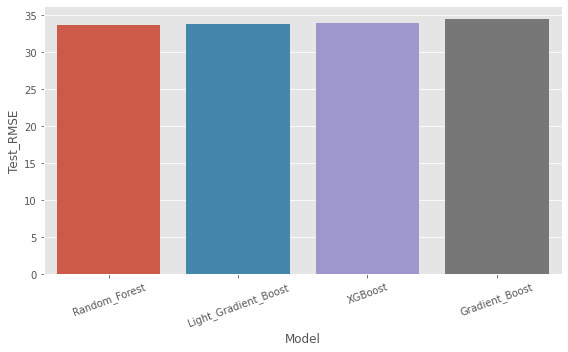

In [475]:
models = ['Light_Gradient_Boost','Gradient_Boost','Random_Forest','XGBoost']
test_rmse = [33.74,34.42,33.67,33.96]
model_rmse = pd.DataFrame(models,test_rmse).reset_index().rename(columns={'index':'Test_RMSE',0:'Model'})[['Model','Test_RMSE']]
model_rmse
plt.figure(figsize=[8,5])
sns.barplot(x='Model',y='Test_RMSE',data=model_rmse.sort_values('Test_RMSE'))
plt.xticks(rotation=20);
#plt.ylim(33,34.5)
plt.tight_layout()

Next,run walk forward validations (hourly forecasts) for the above models to make 200 predictions.

Initially, run for a random split as done before and using all features.

Light Gradient Boost

Initial Train size:  22541 Prediction size:  205
Initial train size:  22541 Prediction size:  205
Fitted 20 / 205 th model
Fitted 40 / 205 th model
Fitted 60 / 205 th model
Fitted 80 / 205 th model
Fitted 100 / 205 th model
Fitted 120 / 205 th model
Fitted 140 / 205 th model
Fitted 160 / 205 th model
Fitted 180 / 205 th model
Fitted 200 / 205 th model
205 205
 Average Test RMSE:  28.294647295180738
 Average Train RMSE:  32.043394944472496


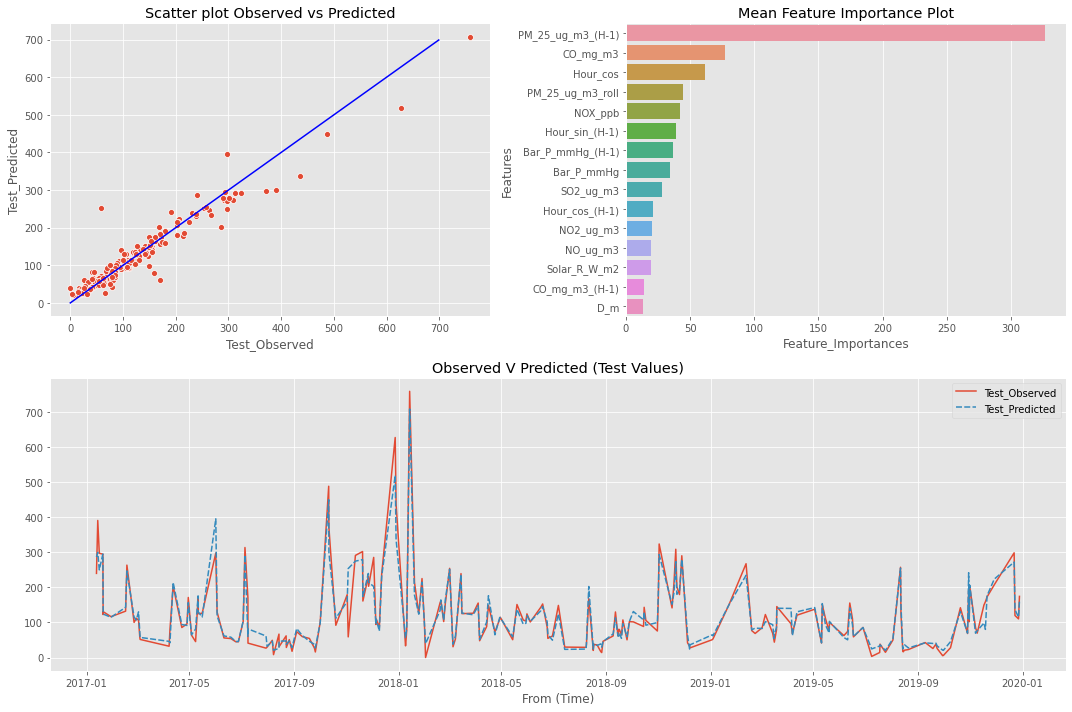

In [558]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = n_cols
mod = LGBMRegressor(learning_rate=0.05,n_estimators=100,num_leaves=10)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.009,random=True,rolling=True,w=2)

Initial train size:  22546 Prediction size:  200
Fitted 20 / 200 th model
Fitted 40 / 200 th model
Fitted 60 / 200 th model
Fitted 80 / 200 th model
Fitted 100 / 200 th model
Fitted 120 / 200 th model
Fitted 140 / 200 th model
Fitted 160 / 200 th model
Fitted 180 / 200 th model
Fitted 200 / 200 th model
200 200
 Average Test RMSE:  25.706875478842967
 Average Train RMSE:  32.02739899936347


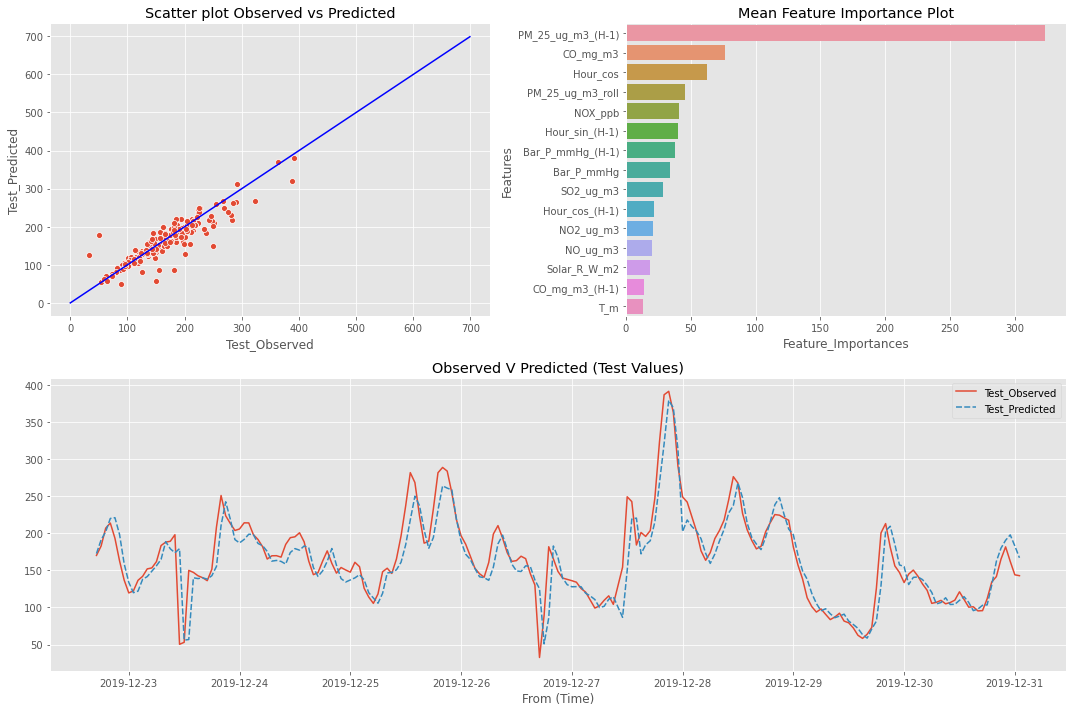

In [600]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = n_cols
mod = LGBMRegressor(learning_rate=0.05,n_estimators=100,num_leaves=10)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.009,random=False,rolling=True,w=2)

s
Next, use the hyper-parameters seen in the exercises above for the next models. Also 1 lag and time features will be used in the model. Starting with LGBM.

Initial train size:  22546 Prediction size:  200
Fitted 20 / 200 th model
Fitted 40 / 200 th model
Fitted 60 / 200 th model
Fitted 80 / 200 th model
Fitted 100 / 200 th model
Fitted 120 / 200 th model
Fitted 140 / 200 th model
Fitted 160 / 200 th model
Fitted 180 / 200 th model
Fitted 200 / 200 th model
200 200
 Average Test RMSE:  25.617480758088178
 Average Train RMSE:  35.144061277614256


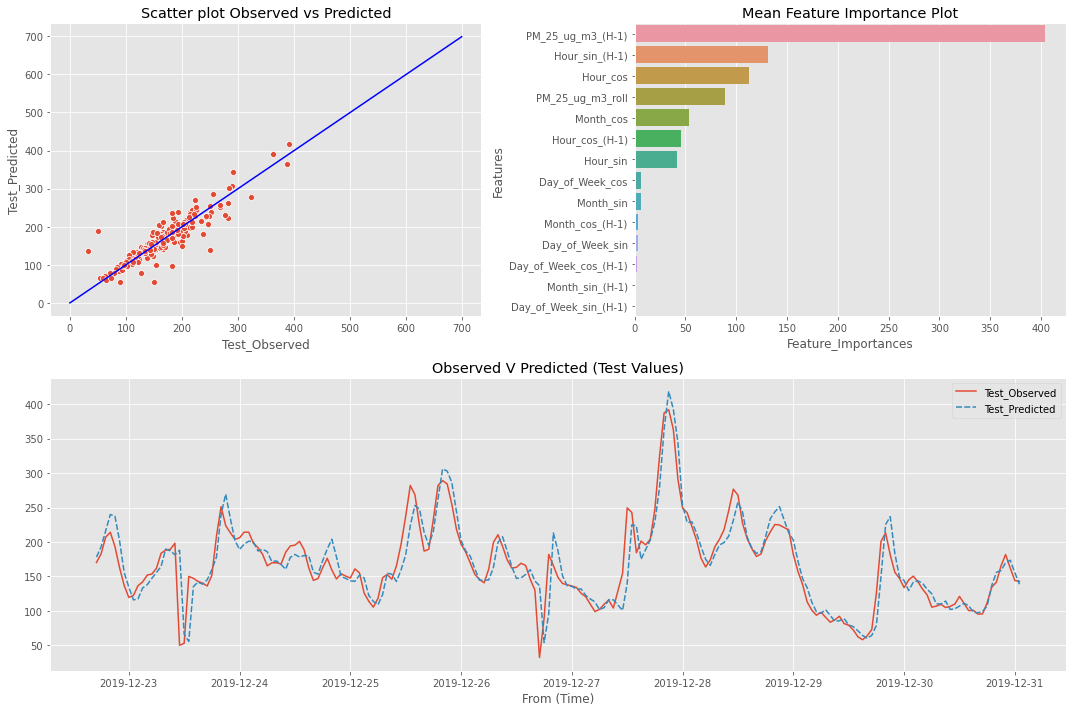

In [550]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = opt_cols
mod = LGBMRegressor(learning_rate=0.05,n_estimators=100,num_leaves=10)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.0126,random=False,rolling=True,w=2)

XGBoost Model

Initial train size:  22546 Prediction size:  200
Fitted 20 / 200 th model
Fitted 40 / 200 th model
Fitted 60 / 200 th model
Fitted 80 / 200 th model
Fitted 100 / 200 th model
Fitted 120 / 200 th model
Fitted 140 / 200 th model
Fitted 160 / 200 th model
Fitted 180 / 200 th model
Fitted 200 / 200 th model
200 200
 Average Test RMSE:  25.24945499532183
 Average Train RMSE:  35.06123285395925


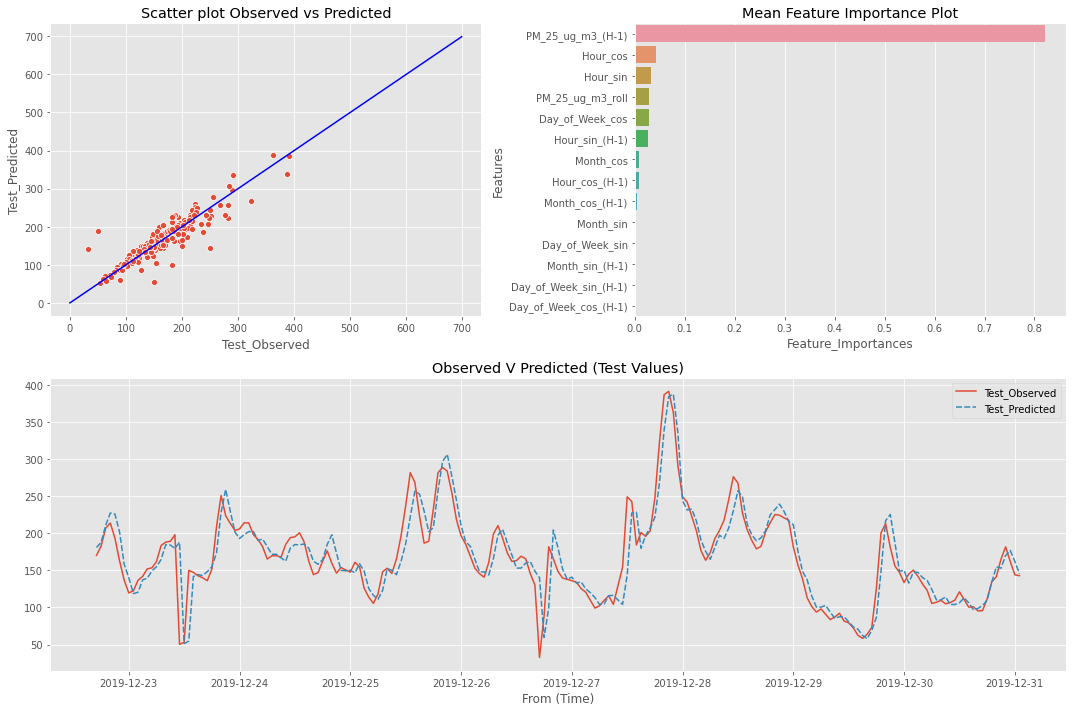

In [552]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = opt_cols
mod = XGBRegressor(eta=0.1,gamma=0,max_depth=2,min_child_weight=5,n_estimators=100)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.0126,random=False,rolling=True,w=2)

Gradient Boost Model

Initial train size:  22546 Prediction size:  200
Fitted 20 / 200 th model
Fitted 40 / 200 th model
Fitted 60 / 200 th model
Fitted 80 / 200 th model
Fitted 100 / 200 th model
Fitted 120 / 200 th model
Fitted 140 / 200 th model
Fitted 160 / 200 th model
Fitted 180 / 200 th model
Fitted 200 / 200 th model
200 200
 Average Test RMSE:  25.658783185560562
 Average Train RMSE:  36.43082390316854


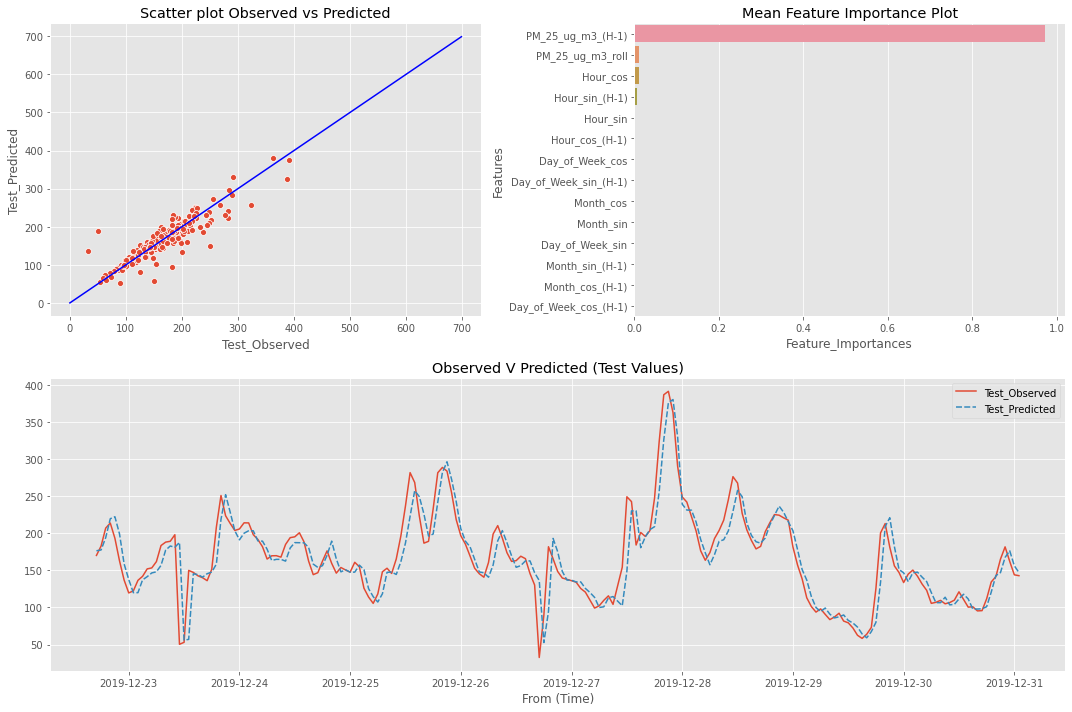

In [553]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = opt_cols
mod = GradientBoostingRegressor(learning_rate=0.05,max_depth=2,n_estimators=100)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.0126,random=False,rolling=True,w=2)

Random Forest Model

Initial train size:  22546 Prediction size:  200
Fitted 20 / 200 th model
Fitted 40 / 200 th model
Fitted 60 / 200 th model
Fitted 80 / 200 th model
Fitted 100 / 200 th model
Fitted 120 / 200 th model
Fitted 140 / 200 th model
Fitted 160 / 200 th model
Fitted 180 / 200 th model
Fitted 200 / 200 th model
200 200
 Average Test RMSE:  25.514507085379204
 Average Train RMSE:  31.953624241235094


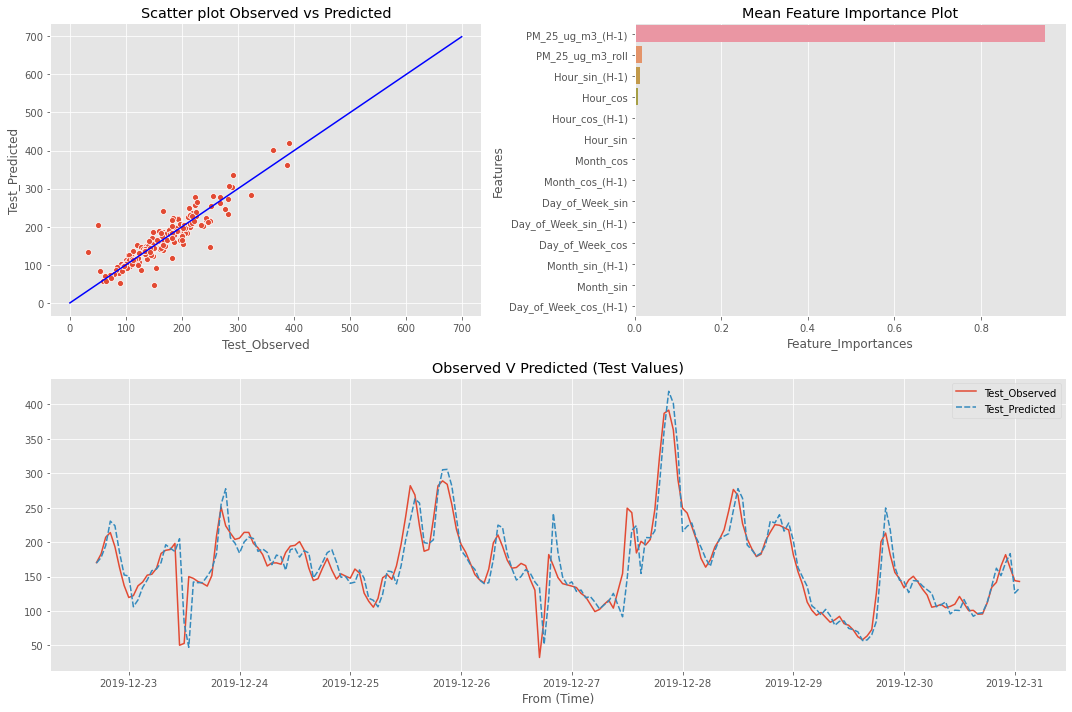

In [554]:
start = '2017-01-01 00:00:00'
end = '2019-12-31 01:00:00'
cols = opt_cols
mod = RandomForestRegressor(max_depth=50,min_samples_leaf=10,n_estimators=100)
results = walk_forward(df1,start,end,mod,cols,periods=1,log_c=False,
                       predictions=200,test_size=0.0126,random=False,rolling=True,w=2)

Performances as was before are similar across models.

Comparing across models, using the right features is the common factor for improving RMSE. The RMSE performance is similar across all models. 
While running with time series split as well as hourly walk forward validation, the train error appeared to increase while test error dropped with increasing sizes of the training data.
With the largest training set for hourly walk forward validation, the test error was ~25 whereas the average test error was ~34 where the training size was smaller.
In all cases, the size of the test data (# of predictions) was kept constant.

In [151]:
# #Multiple Time Series Splits
# ts_spl = TimeSeriesSplit(n_splits=3)
# for tr, val in ts_spl.split(df1.loc[start:end,:]):
#     X_train = df1.iloc[tr]
#     X_val = df1.iloc[val]
#     plt.figure()
#     plt.plot(X_train.index,X_train['PM_25_ug_m3'])
#     plt.plot(X_val.index,X_val['PM_25_ug_m3'])
#     print(tr,val)
#     print(X_train.shape, X_val.shape)
#     print(len(X_train),len(X_val))


# def mod_eval(DF,start,end,mod,cols,periods,rolling,w,impute=True,predictions=100,test_size=0.2,lags=False,
#              random=True,log_c=True,plots=True):
#     #Define data to be used for the model
    
#     target = 'PM_25_ug_m3'
    
#     if log_c == True:

#         target = 'PM_25_ug_m3_log'
    
#     df = DF[cols].loc[start:end,:].sort_index()
    
#     # Add lag variables if needed
    
#     if lags == True:
#         df = add_lags(df.copy(),target,rolling,w,periods)
#         print('periods: ',periods,'window: ',w)
#     if random == True: 
#         #Randomly split into train and test sets without considering the temporal order
#         #print(df.columns)
#         X = df.drop([target],axis=1)
#         y = df[target]
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=100)
#         train = pd.concat([X_train,y_train],axis=1)
#         test = pd.concat([X_test,y_test],axis=1)
#         train_time = train.index
#         test_time = test.index
#         #tren = train
#         #tst = test
        
#     elif random == False:
#         train = df.iloc[:-predictions,:]
#         test = df.iloc[-predictions:,:]
#         test_time = test.index
#         train_time = train.index
#         #tren = train
#         #tst = test
    
#     #Impute all missing data with mean
#     if impute == True:
#         sm = SimpleImputer(strategy='mean')
#         sm.fit(train)
#         train = pd.DataFrame(sm.transform(train),columns=train.columns)
#         test = pd.DataFrame(sm.transform(test),columns=test.columns)
    
#     #Scale the data before fitting
#     sl_x = StandardScaler()
#     sl_y = StandardScaler()
#     xcols = train.drop([target],axis=1).columns
#     #print(train.columns)
#     sl_x.fit(train[xcols])
#     sl_y.fit(train[target].values.reshape(-1,1))
    
#     train_y = pd.DataFrame(sl_y.transform(train[target].values.reshape(-1,1)),columns=[target])
#     train = pd.DataFrame(sl_x.transform(train[xcols]),columns=xcols)
#     train = pd.concat([train,train_y],axis=1)
    
#     test_y = pd.DataFrame(sl_y.transform(test[target].values.reshape(-1,1)),columns=[target])
#     test = pd.DataFrame(sl_x.transform(test[xcols]),columns=xcols)
#     test = pd.concat([test,test_y],axis=1)
    
#     #Fit a model
#     X_train = train.drop([target],axis=1)
#     X_test = test.drop([target],axis=1)
#     y_train = train[target]
#     y_test = test[target]
#     mod.fit(X_train,y_train)
    
#     #Predict for train and test values
#     y_test_pred = mod.predict(X_test)
#     y_train_pred = mod.predict(X_train)
    
#     #Inverse transform train, test as well as predicted train and test values
#     y_train = sl_y.inverse_transform(y_train.values.reshape(-1,1))
#     y_test = sl_y.inverse_transform(y_test.values.reshape(-1,1))
#     y_train_pred = sl_y.inverse_transform(y_train_pred)
#     y_test_pred = sl_y.inverse_transform(y_test_pred)
# #     print(y_train_pred)
# #     print(y_test_pred)
#     if log_c == True:
#         #Inverse transform if log features
#         y_test_pred = np.exp(y_test_pred)-1
#         y_train_pred = np.exp(y_train_pred)-1
#         y_test = np.exp(y_test)-1
#         y_train = np.exp(y_train)-1
    
#     #Results
    
#     if random == True:
        
#         print('Test Set- ','Mean Absolute Error: ',round(mae(y_test,y_test_pred),2),
#               'RMSE: ',round(np.sqrt(mse(y_test,y_test_pred)),2))
#         print('Train Set- ','Mean Absolute Error Train: ',round(mae(y_train,y_train_pred),2),
#               'RMSE: ',round(np.sqrt(mse(y_train,y_train_pred)),2))
#         obs_test = pd.DataFrame(y_test).rename(columns={0:'Test_PM25'}).set_index(test_time)
#         obs_train = pd.DataFrame(y_train).rename(columns={0:'Train_PM25'}).set_index(train_time)
#         pred_train = pd.DataFrame(y_train_pred).rename(columns={0:'Predicted_Train_PM25'}).set_index(train_time)
#         pred_test = pd.DataFrame(y_test_pred).rename(columns={0:'Predicted_Test_PM25'}).set_index(test_time)
#         results_train = pd.concat([obs_train,pred_train],axis=1)
#         results_test = pd.concat([obs_test,pred_test],axis=1)
#         print('Random split predictions for all ',len(pred_test) ,' test set points')
        
#         if plots == True:
#             #Plots
#             gs = gridspec.GridSpec(1,2)
#             fig = plt.figure(figsize=(15,10))

#             ax1 = fig.add_subplot(gs[0,0])
#             ax1.title.set_text('Scatter plot for Test Set: Observed vs Predicted')
#             ax1.set(xlabel='Test Set PM2.5 Values',ylabel='Predicted Test Set PM2.5 Values')
#             xy = np.arange(0,700)
#             sns.lineplot(xy,xy,ax= ax1,color='blue')
#             sns.scatterplot(results_test['Test_PM25'],results_test['Predicted_Test_PM25'],ax=ax1)
            
#             ax2 = fig.add_subplot(gs[0,1])
#             ax2.title.set_text('Feature Importance')
#             imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
#             imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
#             sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)
#             plt.tight_layout()
#             #results = {'obs':obs,'pred':pred,'rmse':RMSE_ind}
    
#     else:
#         print('Train Set- ','Mean Absolute Error Train: ',round(mae(y_train,y_train_pred),2),
#               'RMSE: ',round(np.sqrt(mse(y_train,y_train_pred)),2))
#         print('Test Set- ','Mean Absolute Error: ',round(mae(y_test,y_test_pred),2),
#               'RMSE: ',round(np.sqrt(mse(y_test,y_test_pred)),2))
#         obs_test = pd.DataFrame(y_test).rename(columns={0:'Test_PM25'}).set_index(test_time)
#         obs_train = pd.DataFrame(y_train).rename(columns={0:'Train_PM25'}).set_index(train_time)
#         pred_train = pd.DataFrame(y_train_pred).rename(columns={0:'Predicted_Train_PM25'}).set_index(train_time)
#         pred_test = pd.DataFrame(y_test_pred).rename(columns={0:'Predicted_Test_PM25'}).set_index(test_time)
#         results_train = pd.concat([obs_train,pred_train],axis=1)
#         results_test = pd.concat([obs_test,pred_test],axis=1)
#         print('Time based predictions for all ',predictions ,' requested points')
        
#         if plots == True:
#             #Plots
#             gs = gridspec.GridSpec(2,2)
#             fig = plt.figure(figsize=(15,10))

#             ax1 = fig.add_subplot(gs[0,0])
#             ax1.title.set_text('Scatter plot for Test Set: Observed vs Predicted')
#             ax1.set(xlabel='Test Set PM2.5 Values',ylabel='Predicted Test Set PM2.5 Values')
#             xy = np.arange(0,600)
#             sns.lineplot(xy,xy,ax= ax1,color='blue')
#             sns.scatterplot(results_test['Test_PM25'],results_test['Predicted_Test_PM25'],ax=ax1)

#             ax2 = fig.add_subplot(gs[0,1])
#             ax2.title.set_text('Feature Importance')
#             imp = pd.DataFrame(mod.feature_importances_,X_train.columns).reset_index()
#             imp = imp.rename(columns={'index':'Features',0:'Feature_Importance'})
#             sns.barplot(x='Feature_Importance',y='Features',data=imp.nlargest(15,'Feature_Importance'),ax=ax2)

#             ax3 = fig.add_subplot(gs[1,:])
#             ax3.title.set_text('Test Set Observed vs Predicted Series')
#             sns.lineplot(data=results_test,ax=ax3)
#             plt.xticks(rotation=40)

#             plt.tight_layout()
#             #ax1 = plt.plot(c.index,c['Observed_PM25'])
#             #ax2 = plt.plot(c.index,c['Predicted_PM25'])
#             #ax1 = (c['Observed_PM25']).plot(label='Observed')
#             #ax2 = (c['Predicted_PM25']).plot(label='Predicted')
#             #ax3 = df1.loc['2017-11-18 12:00:00':'2017-11-30 23:00:00','PM_25_ug_m3'].plot()
        
#     return results_train,results_test